# Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know the following things about the prospective properties:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

In [1]:
# import the required libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

import statsmodels
import statsmodels.api as sm

import sklearn
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## Reading and Understanding the data

In [2]:
price = pd.read_csv("train.csv") # read the data

In [3]:
price.shape # looked at the shape of the data

(1460, 81)

In [4]:
price.info() # check what are the features and their corresponding null values.... 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
null_perc = round(price.isnull().mean()*100,2)
null_perc   

# The null percentage of columns tells us which are the columns to drop immediatly.

Id                0.00
MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
                 ...  
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleCondition     0.00
SalePrice         0.00
Length: 81, dtype: float64

In [6]:
# Lets see the columns with null percentage greater than 45% and drop them immediatly,
# as high null value percentage won't help in our final model. 

null_perc[null_perc > 45]

Alley          93.77
FireplaceQu    47.26
PoolQC         99.52
Fence          80.75
MiscFeature    96.30
dtype: float64

In [7]:
price= price.drop(['FireplaceQu', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], 1) # droped columns with high null percentage.

In [8]:
null_perc = round(price.isnull().mean()*100,2)
null_perc[null_perc != 0]                       # looked at columns which are having non null values.

LotFrontage     17.74
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
dtype: float64

In [9]:
price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [10]:
cat_vars = price.select_dtypes(include = 'object') # create a categorical dataframe whose dtype is an 'Object'

In [11]:
cat_vars.columns #columns of categorical dataframe

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [12]:
num_vars = price.select_dtypes(include = ['int64', 'float64']) # created a df for numerical variables.

In [13]:
num_vars.columns # looked at numerical columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [14]:
for col in cat_vars.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ') # value counts of all the categorical columns
    display(cat_vars[col].value_counts())

----------------------------------------MSZoning---------------------------------------- - 

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

----------------------------------------Street---------------------------------------- - 

Pave    1454
Grvl       6
Name: Street, dtype: int64

----------------------------------------LotShape---------------------------------------- - 

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

----------------------------------------LandContour---------------------------------------- - 

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

----------------------------------------Utilities---------------------------------------- - 

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

----------------------------------------LotConfig---------------------------------------- - 

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

----------------------------------------LandSlope---------------------------------------- - 

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

----------------------------------------Neighborhood---------------------------------------- - 

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

----------------------------------------Condition1---------------------------------------- - 

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

----------------------------------------Condition2---------------------------------------- - 

Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAn         1
RRAe         1
PosA         1
Name: Condition2, dtype: int64

----------------------------------------BldgType---------------------------------------- - 

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

----------------------------------------HouseStyle---------------------------------------- - 

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

----------------------------------------RoofStyle---------------------------------------- - 

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

----------------------------------------RoofMatl---------------------------------------- - 

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Roll          1
Metal         1
Membran       1
Name: RoofMatl, dtype: int64

----------------------------------------Exterior1st---------------------------------------- - 

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
CBlock       1
ImStucc      1
AsphShn      1
Name: Exterior1st, dtype: int64

----------------------------------------Exterior2nd---------------------------------------- - 

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

----------------------------------------MasVnrType---------------------------------------- - 

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

----------------------------------------ExterQual---------------------------------------- - 

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

----------------------------------------ExterCond---------------------------------------- - 

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

----------------------------------------Foundation---------------------------------------- - 

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

----------------------------------------BsmtQual---------------------------------------- - 

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

----------------------------------------BsmtCond---------------------------------------- - 

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

----------------------------------------BsmtExposure---------------------------------------- - 

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

----------------------------------------BsmtFinType1---------------------------------------- - 

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

----------------------------------------BsmtFinType2---------------------------------------- - 

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

----------------------------------------Heating---------------------------------------- - 

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

----------------------------------------HeatingQC---------------------------------------- - 

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

----------------------------------------CentralAir---------------------------------------- - 

Y    1365
N      95
Name: CentralAir, dtype: int64

----------------------------------------Electrical---------------------------------------- - 

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

----------------------------------------KitchenQual---------------------------------------- - 

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

----------------------------------------Functional---------------------------------------- - 

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

----------------------------------------GarageType---------------------------------------- - 

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

----------------------------------------GarageFinish---------------------------------------- - 

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

----------------------------------------GarageQual---------------------------------------- - 

TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

----------------------------------------GarageCond---------------------------------------- - 

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

----------------------------------------PavedDrive---------------------------------------- - 

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

----------------------------------------SaleType---------------------------------------- - 

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

----------------------------------------SaleCondition---------------------------------------- - 

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [15]:
for col in cat_vars.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ') # percentage value counts of categorical columns
    display(cat_vars[col].value_counts(normalize = True))

----------------------------------------MSZoning---------------------------------------- - 

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64

----------------------------------------Street---------------------------------------- - 

Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64

----------------------------------------LotShape---------------------------------------- - 

Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64

----------------------------------------LandContour---------------------------------------- - 

Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64

----------------------------------------Utilities---------------------------------------- - 

AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64

----------------------------------------LotConfig---------------------------------------- - 

Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64

----------------------------------------LandSlope---------------------------------------- - 

Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64

----------------------------------------Neighborhood---------------------------------------- - 

NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    0.028082
Timber     0.026027
IDOTRR     0.025342
ClearCr    0.019178
SWISU      0.017123
StoneBr    0.017123
MeadowV    0.011644
Blmngtn    0.011644
BrDale     0.010959
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: Neighborhood, dtype: float64

----------------------------------------Condition1---------------------------------------- - 

Norm      0.863014
Feedr     0.055479
Artery    0.032877
RRAn      0.017808
PosN      0.013014
RRAe      0.007534
PosA      0.005479
RRNn      0.003425
RRNe      0.001370
Name: Condition1, dtype: float64

----------------------------------------Condition2---------------------------------------- - 

Norm      0.989726
Feedr     0.004110
PosN      0.001370
RRNn      0.001370
Artery    0.001370
RRAn      0.000685
RRAe      0.000685
PosA      0.000685
Name: Condition2, dtype: float64

----------------------------------------BldgType---------------------------------------- - 

1Fam      0.835616
TwnhsE    0.078082
Duplex    0.035616
Twnhs     0.029452
2fmCon    0.021233
Name: BldgType, dtype: float64

----------------------------------------HouseStyle---------------------------------------- - 

1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
SLvl      0.044521
SFoyer    0.025342
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: HouseStyle, dtype: float64

----------------------------------------RoofStyle---------------------------------------- - 

Gable      0.781507
Hip        0.195890
Flat       0.008904
Gambrel    0.007534
Mansard    0.004795
Shed       0.001370
Name: RoofStyle, dtype: float64

----------------------------------------RoofMatl---------------------------------------- - 

CompShg    0.982192
Tar&Grv    0.007534
WdShngl    0.004110
WdShake    0.003425
ClyTile    0.000685
Roll       0.000685
Metal      0.000685
Membran    0.000685
Name: RoofMatl, dtype: float64

----------------------------------------Exterior1st---------------------------------------- - 

VinylSd    0.352740
HdBoard    0.152055
MetalSd    0.150685
Wd Sdng    0.141096
Plywood    0.073973
CemntBd    0.041781
BrkFace    0.034247
WdShing    0.017808
Stucco     0.017123
AsbShng    0.013699
BrkComm    0.001370
Stone      0.001370
CBlock     0.000685
ImStucc    0.000685
AsphShn    0.000685
Name: Exterior1st, dtype: float64

----------------------------------------Exterior2nd---------------------------------------- - 

VinylSd    0.345205
MetalSd    0.146575
HdBoard    0.141781
Wd Sdng    0.134932
Plywood    0.097260
CmentBd    0.041096
Wd Shng    0.026027
Stucco     0.017808
BrkFace    0.017123
AsbShng    0.013699
ImStucc    0.006849
Brk Cmn    0.004795
Stone      0.003425
AsphShn    0.002055
CBlock     0.000685
Other      0.000685
Name: Exterior2nd, dtype: float64

----------------------------------------MasVnrType---------------------------------------- - 

None       0.595041
BrkFace    0.306474
Stone      0.088154
BrkCmn     0.010331
Name: MasVnrType, dtype: float64

----------------------------------------ExterQual---------------------------------------- - 

TA    0.620548
Gd    0.334247
Ex    0.035616
Fa    0.009589
Name: ExterQual, dtype: float64

----------------------------------------ExterCond---------------------------------------- - 

TA    0.878082
Gd    0.100000
Fa    0.019178
Ex    0.002055
Po    0.000685
Name: ExterCond, dtype: float64

----------------------------------------Foundation---------------------------------------- - 

PConc     0.443151
CBlock    0.434247
BrkTil    0.100000
Slab      0.016438
Stone     0.004110
Wood      0.002055
Name: Foundation, dtype: float64

----------------------------------------BsmtQual---------------------------------------- - 

TA    0.456079
Gd    0.434294
Ex    0.085032
Fa    0.024596
Name: BsmtQual, dtype: float64

----------------------------------------BsmtCond---------------------------------------- - 

TA    0.921293
Gd    0.045678
Fa    0.031623
Po    0.001405
Name: BsmtCond, dtype: float64

----------------------------------------BsmtExposure---------------------------------------- - 

No    0.670183
Av    0.155415
Gd    0.094233
Mn    0.080169
Name: BsmtExposure, dtype: float64

----------------------------------------BsmtFinType1---------------------------------------- - 

Unf    0.302178
GLQ    0.293746
ALQ    0.154603
BLQ    0.104006
Rec    0.093465
LwQ    0.052003
Name: BsmtFinType1, dtype: float64

----------------------------------------BsmtFinType2---------------------------------------- - 

Unf    0.883263
Rec    0.037975
LwQ    0.032349
BLQ    0.023207
ALQ    0.013361
GLQ    0.009845
Name: BsmtFinType2, dtype: float64

----------------------------------------Heating---------------------------------------- - 

GasA     0.978082
GasW     0.012329
Grav     0.004795
Wall     0.002740
OthW     0.001370
Floor    0.000685
Name: Heating, dtype: float64

----------------------------------------HeatingQC---------------------------------------- - 

Ex    0.507534
TA    0.293151
Gd    0.165068
Fa    0.033562
Po    0.000685
Name: HeatingQC, dtype: float64

----------------------------------------CentralAir---------------------------------------- - 

Y    0.934932
N    0.065068
Name: CentralAir, dtype: float64

----------------------------------------Electrical---------------------------------------- - 

SBrkr    0.914325
FuseA    0.064428
FuseF    0.018506
FuseP    0.002056
Mix      0.000685
Name: Electrical, dtype: float64

----------------------------------------KitchenQual---------------------------------------- - 

TA    0.503425
Gd    0.401370
Ex    0.068493
Fa    0.026712
Name: KitchenQual, dtype: float64

----------------------------------------Functional---------------------------------------- - 

Typ     0.931507
Min2    0.023288
Min1    0.021233
Mod     0.010274
Maj1    0.009589
Maj2    0.003425
Sev     0.000685
Name: Functional, dtype: float64

----------------------------------------GarageType---------------------------------------- - 

Attchd     0.630892
Detchd     0.280638
BuiltIn    0.063814
Basment    0.013778
CarPort    0.006526
2Types     0.004351
Name: GarageType, dtype: float64

----------------------------------------GarageFinish---------------------------------------- - 

Unf    0.438724
RFn    0.306019
Fin    0.255257
Name: GarageFinish, dtype: float64

----------------------------------------GarageQual---------------------------------------- - 

TA    0.950689
Fa    0.034808
Gd    0.010152
Po    0.002175
Ex    0.002175
Name: GarageQual, dtype: float64

----------------------------------------GarageCond---------------------------------------- - 

TA    0.961566
Fa    0.025381
Gd    0.006526
Po    0.005076
Ex    0.001450
Name: GarageCond, dtype: float64

----------------------------------------PavedDrive---------------------------------------- - 

Y    0.917808
N    0.061644
P    0.020548
Name: PavedDrive, dtype: float64

----------------------------------------SaleType---------------------------------------- - 

WD       0.867808
New      0.083562
COD      0.029452
ConLD    0.006164
ConLI    0.003425
ConLw    0.003425
CWD      0.002740
Oth      0.002055
Con      0.001370
Name: SaleType, dtype: float64

----------------------------------------SaleCondition---------------------------------------- - 

Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64

In [16]:
skewed_vars = cat_vars[['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 
                        'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 
                        'Electrical','Functional', 'GarageQual', 'GarageCond', 'PavedDrive','SaleType'] ]   
# skewed categorical columns

In [17]:
price = price.drop(skewed_vars, 1) # drop the skewed variables

In [18]:
cat_vars = price.select_dtypes(include = 'object')
cat_vars.columns 

Index(['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish',
       'SaleCondition'],
      dtype='object')

In [19]:
for col in cat_vars.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(cat_vars[col].value_counts(normalize = True))

----------------------------------------MSZoning---------------------------------------- - 

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64

----------------------------------------LotShape---------------------------------------- - 

Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64

----------------------------------------LotConfig---------------------------------------- - 

Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64

----------------------------------------Neighborhood---------------------------------------- - 

NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    0.028082
Timber     0.026027
IDOTRR     0.025342
ClearCr    0.019178
SWISU      0.017123
StoneBr    0.017123
MeadowV    0.011644
Blmngtn    0.011644
BrDale     0.010959
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: Neighborhood, dtype: float64

----------------------------------------BldgType---------------------------------------- - 

1Fam      0.835616
TwnhsE    0.078082
Duplex    0.035616
Twnhs     0.029452
2fmCon    0.021233
Name: BldgType, dtype: float64

----------------------------------------HouseStyle---------------------------------------- - 

1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
SLvl      0.044521
SFoyer    0.025342
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: HouseStyle, dtype: float64

----------------------------------------RoofStyle---------------------------------------- - 

Gable      0.781507
Hip        0.195890
Flat       0.008904
Gambrel    0.007534
Mansard    0.004795
Shed       0.001370
Name: RoofStyle, dtype: float64

----------------------------------------Exterior1st---------------------------------------- - 

VinylSd    0.352740
HdBoard    0.152055
MetalSd    0.150685
Wd Sdng    0.141096
Plywood    0.073973
CemntBd    0.041781
BrkFace    0.034247
WdShing    0.017808
Stucco     0.017123
AsbShng    0.013699
BrkComm    0.001370
Stone      0.001370
CBlock     0.000685
ImStucc    0.000685
AsphShn    0.000685
Name: Exterior1st, dtype: float64

----------------------------------------Exterior2nd---------------------------------------- - 

VinylSd    0.345205
MetalSd    0.146575
HdBoard    0.141781
Wd Sdng    0.134932
Plywood    0.097260
CmentBd    0.041096
Wd Shng    0.026027
Stucco     0.017808
BrkFace    0.017123
AsbShng    0.013699
ImStucc    0.006849
Brk Cmn    0.004795
Stone      0.003425
AsphShn    0.002055
CBlock     0.000685
Other      0.000685
Name: Exterior2nd, dtype: float64

----------------------------------------MasVnrType---------------------------------------- - 

None       0.595041
BrkFace    0.306474
Stone      0.088154
BrkCmn     0.010331
Name: MasVnrType, dtype: float64

----------------------------------------ExterQual---------------------------------------- - 

TA    0.620548
Gd    0.334247
Ex    0.035616
Fa    0.009589
Name: ExterQual, dtype: float64

----------------------------------------Foundation---------------------------------------- - 

PConc     0.443151
CBlock    0.434247
BrkTil    0.100000
Slab      0.016438
Stone     0.004110
Wood      0.002055
Name: Foundation, dtype: float64

----------------------------------------BsmtQual---------------------------------------- - 

TA    0.456079
Gd    0.434294
Ex    0.085032
Fa    0.024596
Name: BsmtQual, dtype: float64

----------------------------------------BsmtExposure---------------------------------------- - 

No    0.670183
Av    0.155415
Gd    0.094233
Mn    0.080169
Name: BsmtExposure, dtype: float64

----------------------------------------BsmtFinType1---------------------------------------- - 

Unf    0.302178
GLQ    0.293746
ALQ    0.154603
BLQ    0.104006
Rec    0.093465
LwQ    0.052003
Name: BsmtFinType1, dtype: float64

----------------------------------------HeatingQC---------------------------------------- - 

Ex    0.507534
TA    0.293151
Gd    0.165068
Fa    0.033562
Po    0.000685
Name: HeatingQC, dtype: float64

----------------------------------------KitchenQual---------------------------------------- - 

TA    0.503425
Gd    0.401370
Ex    0.068493
Fa    0.026712
Name: KitchenQual, dtype: float64

----------------------------------------GarageType---------------------------------------- - 

Attchd     0.630892
Detchd     0.280638
BuiltIn    0.063814
Basment    0.013778
CarPort    0.006526
2Types     0.004351
Name: GarageType, dtype: float64

----------------------------------------GarageFinish---------------------------------------- - 

Unf    0.438724
RFn    0.306019
Fin    0.255257
Name: GarageFinish, dtype: float64

----------------------------------------SaleCondition---------------------------------------- - 

Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64

In [20]:
cat_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   LotShape       1460 non-null   object
 2   LotConfig      1460 non-null   object
 3   Neighborhood   1460 non-null   object
 4   BldgType       1460 non-null   object
 5   HouseStyle     1460 non-null   object
 6   RoofStyle      1460 non-null   object
 7   Exterior1st    1460 non-null   object
 8   Exterior2nd    1460 non-null   object
 9   MasVnrType     1452 non-null   object
 10  ExterQual      1460 non-null   object
 11  Foundation     1460 non-null   object
 12  BsmtQual       1423 non-null   object
 13  BsmtExposure   1422 non-null   object
 14  BsmtFinType1   1423 non-null   object
 15  HeatingQC      1460 non-null   object
 16  KitchenQual    1460 non-null   object
 17  GarageType     1379 non-null   object
 18  GarageFinish   1379 non-null

In [21]:
cat_vars.isnull().sum() #

MSZoning          0
LotShape          0
LotConfig         0
Neighborhood      0
BldgType          0
HouseStyle        0
RoofStyle         0
Exterior1st       0
Exterior2nd       0
MasVnrType        8
ExterQual         0
Foundation        0
BsmtQual         37
BsmtExposure     38
BsmtFinType1     37
HeatingQC         0
KitchenQual       0
GarageType       81
GarageFinish     81
SaleCondition     0
dtype: int64

In [22]:
# Fill the NAN cells with mode of that particular .
price.MasVnrType = price.MasVnrType.fillna(price.MasVnrType.mode()[0])
price.BsmtQual = price.BsmtQual.fillna(price.BsmtQual.mode()[0])
price.BsmtExposure = price.BsmtExposure.fillna(price.BsmtExposure.mode()[0])
price.BsmtFinType1 = price.BsmtFinType1.fillna(price.BsmtFinType1.mode()[0])
price.GarageType = price.GarageType.fillna(price.GarageType.mode()[0])
price.GarageFinish = price.GarageFinish.fillna(price.GarageFinish.mode()[0])

In [23]:
price[cat_vars.columns].info() # Null values were been treated properly.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   LotShape       1460 non-null   object
 2   LotConfig      1460 non-null   object
 3   Neighborhood   1460 non-null   object
 4   BldgType       1460 non-null   object
 5   HouseStyle     1460 non-null   object
 6   RoofStyle      1460 non-null   object
 7   Exterior1st    1460 non-null   object
 8   Exterior2nd    1460 non-null   object
 9   MasVnrType     1460 non-null   object
 10  ExterQual      1460 non-null   object
 11  Foundation     1460 non-null   object
 12  BsmtQual       1460 non-null   object
 13  BsmtExposure   1460 non-null   object
 14  BsmtFinType1   1460 non-null   object
 15  HeatingQC      1460 non-null   object
 16  KitchenQual    1460 non-null   object
 17  GarageType     1460 non-null   object
 18  GarageFinish   1460 non-null

In [24]:
cat_vars = price.select_dtypes(include = 'object') 

In [25]:
cat_vars.isnull().sum() # zero null values

MSZoning         0
LotShape         0
LotConfig        0
Neighborhood     0
BldgType         0
HouseStyle       0
RoofStyle        0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
Foundation       0
BsmtQual         0
BsmtExposure     0
BsmtFinType1     0
HeatingQC        0
KitchenQual      0
GarageType       0
GarageFinish     0
SaleCondition    0
dtype: int64

In [26]:
for col in cat_vars.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(cat_vars[col].value_counts(normalize = True))  # Categorical column values after missing value treatment is done.

----------------------------------------MSZoning---------------------------------------- - 

RL         0.788356
RM         0.149315
FV         0.044521
RH         0.010959
C (all)    0.006849
Name: MSZoning, dtype: float64

----------------------------------------LotShape---------------------------------------- - 

Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64

----------------------------------------LotConfig---------------------------------------- - 

Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64

----------------------------------------Neighborhood---------------------------------------- - 

NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    0.028082
Timber     0.026027
IDOTRR     0.025342
ClearCr    0.019178
SWISU      0.017123
StoneBr    0.017123
MeadowV    0.011644
Blmngtn    0.011644
BrDale     0.010959
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: Neighborhood, dtype: float64

----------------------------------------BldgType---------------------------------------- - 

1Fam      0.835616
TwnhsE    0.078082
Duplex    0.035616
Twnhs     0.029452
2fmCon    0.021233
Name: BldgType, dtype: float64

----------------------------------------HouseStyle---------------------------------------- - 

1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
SLvl      0.044521
SFoyer    0.025342
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: HouseStyle, dtype: float64

----------------------------------------RoofStyle---------------------------------------- - 

Gable      0.781507
Hip        0.195890
Flat       0.008904
Gambrel    0.007534
Mansard    0.004795
Shed       0.001370
Name: RoofStyle, dtype: float64

----------------------------------------Exterior1st---------------------------------------- - 

VinylSd    0.352740
HdBoard    0.152055
MetalSd    0.150685
Wd Sdng    0.141096
Plywood    0.073973
CemntBd    0.041781
BrkFace    0.034247
WdShing    0.017808
Stucco     0.017123
AsbShng    0.013699
BrkComm    0.001370
Stone      0.001370
CBlock     0.000685
ImStucc    0.000685
AsphShn    0.000685
Name: Exterior1st, dtype: float64

----------------------------------------Exterior2nd---------------------------------------- - 

VinylSd    0.345205
MetalSd    0.146575
HdBoard    0.141781
Wd Sdng    0.134932
Plywood    0.097260
CmentBd    0.041096
Wd Shng    0.026027
Stucco     0.017808
BrkFace    0.017123
AsbShng    0.013699
ImStucc    0.006849
Brk Cmn    0.004795
Stone      0.003425
AsphShn    0.002055
CBlock     0.000685
Other      0.000685
Name: Exterior2nd, dtype: float64

----------------------------------------MasVnrType---------------------------------------- - 

None       0.597260
BrkFace    0.304795
Stone      0.087671
BrkCmn     0.010274
Name: MasVnrType, dtype: float64

----------------------------------------ExterQual---------------------------------------- - 

TA    0.620548
Gd    0.334247
Ex    0.035616
Fa    0.009589
Name: ExterQual, dtype: float64

----------------------------------------Foundation---------------------------------------- - 

PConc     0.443151
CBlock    0.434247
BrkTil    0.100000
Slab      0.016438
Stone     0.004110
Wood      0.002055
Name: Foundation, dtype: float64

----------------------------------------BsmtQual---------------------------------------- - 

TA    0.469863
Gd    0.423288
Ex    0.082877
Fa    0.023973
Name: BsmtQual, dtype: float64

----------------------------------------BsmtExposure---------------------------------------- - 

No    0.678767
Av    0.151370
Gd    0.091781
Mn    0.078082
Name: BsmtExposure, dtype: float64

----------------------------------------BsmtFinType1---------------------------------------- - 

Unf    0.319863
GLQ    0.286301
ALQ    0.150685
BLQ    0.101370
Rec    0.091096
LwQ    0.050685
Name: BsmtFinType1, dtype: float64

----------------------------------------HeatingQC---------------------------------------- - 

Ex    0.507534
TA    0.293151
Gd    0.165068
Fa    0.033562
Po    0.000685
Name: HeatingQC, dtype: float64

----------------------------------------KitchenQual---------------------------------------- - 

TA    0.503425
Gd    0.401370
Ex    0.068493
Fa    0.026712
Name: KitchenQual, dtype: float64

----------------------------------------GarageType---------------------------------------- - 

Attchd     0.651370
Detchd     0.265068
BuiltIn    0.060274
Basment    0.013014
CarPort    0.006164
2Types     0.004110
Name: GarageType, dtype: float64

----------------------------------------GarageFinish---------------------------------------- - 

Unf    0.469863
RFn    0.289041
Fin    0.241096
Name: GarageFinish, dtype: float64

----------------------------------------SaleCondition---------------------------------------- - 

Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64

## Modifications On Categorical variables:

In [27]:
# Define the changes to be made to 'MSZoning' column and apply the changes

def Change_MSZoning(x):
    if x == 'RL':
        return 'RL'
    elif x == 'RM':
        return 'RM'
    else: 
        return 'Others'

price.MSZoning = price.MSZoning.apply(Change_MSZoning)

In [28]:
# Define the changes to be made to 'LotShape' column and apply the changes

def Change_LotShape(x):
    if x == 'Reg':
        return 'Reg'
    elif x == 'IR1':
        return 'IR1'
    else: 
        return 'Others'

price.LotShape = price.LotShape.apply(Change_LotShape)

In [29]:
# Define the changes to be made to 'Neighborhood' column and apply the changes


def Change_Neighborhood(x):
    if x == 'NAmes':
        return 'NAmes'
    elif x == 'CollgCr':
        return 'CollgCr'
    elif x == 'OldTown':
        return 'OldTown'
    elif x == 'Edwards':
        return 'Edwards'
    else: 
        return 'Others'

price.Neighborhood = price.Neighborhood.apply(Change_Neighborhood)

In [30]:
# Define the changes to be made to 'BldgType' column and apply the changes


def Change_BldgType(x):
    if x == '1Fam':
        return '1Fam'
    elif x == 'TwnhsE':
        return 'TwnhsE'
    else: 
        return 'Others'

price.BldgType = price.BldgType.apply(Change_BldgType)


In [31]:
# Define the changes to be made to 'HouseStyle' column and apply the changes

def Change_HouseStyle(x):
    if x == '1Story':
        return '1Story'
    elif x == '2Story':
        return '2Story'
    elif x == '1.5Fin':
        return '1.5Fin'
    else: 
        return 'Others'

price.HouseStyle = price.HouseStyle.apply(Change_HouseStyle)

In [32]:
# Define the changes to be made to 'RoofStyle, Exterior1st, ExterQual, Foundation, BsmtQual, HeatingQC, KitchenQual, GarageType
# 'SaleCondition' columns and apply the changes


def Change_RoofStyle(x):
    if x == 'Gable':
        return 'Gable'
    elif x == 'Hip':
        return 'Hip'
    else: 
        return 'Others'

def Change_Exterior1st(x):
    if x == 'VinylSd':
        return 'VinylSd'
    elif x == 'HdBoard':
        return 'HdBoard'
    elif x == 'MetalSd':
        return 'MetalSd'
    elif x == 'Wd Sdng':
        return 'WdSdng'
    else: 
        return 'Others'

def Change_ExterQual(x):
    if x == 'TA':
        return 'TA'
    elif x == 'Gd':
        return 'Gd'
    else: 
        return 'Others'

def Change_Foundation(x):
    if x == 'PConc':
        return 'PConc'
    elif x == 'CBlock':
        return 'CBlock'
    else: 
        return 'Others'

def Change_BsmtQual(x):
    if x == 'TA':
        return 'TA'
    elif x == 'Gd':
        return 'Gd'
    else: 
        return 'Others'

def Change_HeatingQC(x):
    if x == 'Ex':
        return 'Ex'
    elif x == 'TA':
        return 'TA'
    elif x == 'Gd':
        return 'Gd'
    else: 
        return 'Others'

def Change_KitchenQual(x):
    if x == 'TA':
        return 'TA'
    elif x == 'Gd':
        return 'Gd'
    else: 
        return 'Others'

def Change_GarageType(x):
    if x == 'Attchd':
        return 'Attchd'
    elif x == 'Detchd':
        return 'Detchd'
    else: 
        return 'Others'

def Change_SaleCondition(x):
    if x == 'Normal':
        return 'Normal'
    elif x == 'Partial':
        return 'Partial'
    else: 
        return 'Others'


price.RoofStyle = price.RoofStyle.apply(Change_RoofStyle)
price.Exterior1st = price.Exterior1st.apply(Change_Exterior1st)
price.ExterQual = price.ExterQual.apply(Change_ExterQual)
price.Foundation = price.Foundation.apply(Change_Foundation)
price.BsmtQual = price.BsmtQual.apply(Change_BsmtQual)
price.HeatingQC = price.HeatingQC.apply(Change_HeatingQC)
price.KitchenQual = price.KitchenQual.apply(Change_KitchenQual)
price.GarageType = price.GarageType.apply(Change_GarageType)
price.SaleCondition = price.SaleCondition.apply(Change_SaleCondition)




In [33]:

def Change_Exterior2nd(x):
    if x == 'VinylSd':
        return 'VinylSd'
    elif x == 'HdBoard':
        return 'HdBoard'
    elif x == 'MetalSd':
        return 'MetalSd'
    elif x == 'Wd Sdng':
        return 'WdSdng'
    elif x == 'Plywood':
        return 'Plywood'
    else: 
        return 'Others'
    
price.Exterior2nd = price.Exterior2nd.apply(Change_Exterior2nd)


In [34]:
def Change_LotConfig(x):
    if x == 'Inside':
        return 'Inside'
    elif x == 'Corner':
        return 'Corner'
    else: 
        return 'Others'
    
price.LotConfig = price.LotConfig.apply(Change_LotConfig)


In [35]:
price.MSSubClass.value_counts(normalize = True)

20     0.367123
60     0.204795
50     0.098630
120    0.059589
30     0.047260
160    0.043151
70     0.041096
80     0.039726
90     0.035616
190    0.020548
85     0.013699
75     0.010959
45     0.008219
180    0.006849
40     0.002740
Name: MSSubClass, dtype: float64

In [36]:

def Change_MSSubClass(x):
    if x == 20:
        return '1_story_Newer'
    elif x == 60:
        return '2_story_Newer'
    elif x == 50:
        return '1.5_story_All_Ages'
    else: 
        return 'Others'
    
price.MSSubClass = price.MSSubClass.apply(Change_MSSubClass)

In [37]:
cat_vars = price.select_dtypes(include = 'object')

for col in cat_vars.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(cat_vars[col].value_counts(normalize = True)) 

----------------------------------------MSSubClass---------------------------------------- - 

1_story_Newer         0.367123
Others                0.329452
2_story_Newer         0.204795
1.5_story_All_Ages    0.098630
Name: MSSubClass, dtype: float64

----------------------------------------MSZoning---------------------------------------- - 

RL        0.788356
RM        0.149315
Others    0.062329
Name: MSZoning, dtype: float64

----------------------------------------LotShape---------------------------------------- - 

Reg       0.633562
IR1       0.331507
Others    0.034932
Name: LotShape, dtype: float64

----------------------------------------LotConfig---------------------------------------- - 

Inside    0.720548
Corner    0.180137
Others    0.099315
Name: LotConfig, dtype: float64

----------------------------------------Neighborhood---------------------------------------- - 

Others     0.597260
NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Name: Neighborhood, dtype: float64

----------------------------------------BldgType---------------------------------------- - 

1Fam      0.835616
Others    0.086301
TwnhsE    0.078082
Name: BldgType, dtype: float64

----------------------------------------HouseStyle---------------------------------------- - 

1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
Others    0.092466
Name: HouseStyle, dtype: float64

----------------------------------------RoofStyle---------------------------------------- - 

Gable     0.781507
Hip       0.195890
Others    0.022603
Name: RoofStyle, dtype: float64

----------------------------------------Exterior1st---------------------------------------- - 

VinylSd    0.352740
Others     0.203425
HdBoard    0.152055
MetalSd    0.150685
WdSdng     0.141096
Name: Exterior1st, dtype: float64

----------------------------------------Exterior2nd---------------------------------------- - 

VinylSd    0.345205
MetalSd    0.146575
HdBoard    0.141781
WdSdng     0.134932
Others     0.134247
Plywood    0.097260
Name: Exterior2nd, dtype: float64

----------------------------------------MasVnrType---------------------------------------- - 

None       0.597260
BrkFace    0.304795
Stone      0.087671
BrkCmn     0.010274
Name: MasVnrType, dtype: float64

----------------------------------------ExterQual---------------------------------------- - 

TA        0.620548
Gd        0.334247
Others    0.045205
Name: ExterQual, dtype: float64

----------------------------------------Foundation---------------------------------------- - 

PConc     0.443151
CBlock    0.434247
Others    0.122603
Name: Foundation, dtype: float64

----------------------------------------BsmtQual---------------------------------------- - 

TA        0.469863
Gd        0.423288
Others    0.106849
Name: BsmtQual, dtype: float64

----------------------------------------BsmtExposure---------------------------------------- - 

No    0.678767
Av    0.151370
Gd    0.091781
Mn    0.078082
Name: BsmtExposure, dtype: float64

----------------------------------------BsmtFinType1---------------------------------------- - 

Unf    0.319863
GLQ    0.286301
ALQ    0.150685
BLQ    0.101370
Rec    0.091096
LwQ    0.050685
Name: BsmtFinType1, dtype: float64

----------------------------------------HeatingQC---------------------------------------- - 

Ex        0.507534
TA        0.293151
Gd        0.165068
Others    0.034247
Name: HeatingQC, dtype: float64

----------------------------------------KitchenQual---------------------------------------- - 

TA        0.503425
Gd        0.401370
Others    0.095205
Name: KitchenQual, dtype: float64

----------------------------------------GarageType---------------------------------------- - 

Attchd    0.651370
Detchd    0.265068
Others    0.083562
Name: GarageType, dtype: float64

----------------------------------------GarageFinish---------------------------------------- - 

Unf    0.469863
RFn    0.289041
Fin    0.241096
Name: GarageFinish, dtype: float64

----------------------------------------SaleCondition---------------------------------------- - 

Normal     0.820548
Others     0.093836
Partial    0.085616
Name: SaleCondition, dtype: float64

In [38]:
cat_vars.columns # Final set of categorical columns and needs to create dummies before scalling 

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'Neighborhood',
       'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'GarageType',
       'GarageFinish', 'SaleCondition'],
      dtype='object')

In [39]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(price[['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC',
       'KitchenQual', 'GarageType', 'GarageFinish', 'SaleCondition', 'MSSubClass']], drop_first=True)

# Adding the results to the master dataframe
price = pd.concat([price, dummy1], axis=1)

In [40]:
price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,BldgType,HouseStyle,...,KitchenQual_TA,GarageType_Detchd,GarageType_Others,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Others,SaleCondition_Partial,MSSubClass_1_story_Newer,MSSubClass_2_story_Newer,MSSubClass_Others
0,1,2_story_Newer,RL,65.0,8450,Reg,Inside,CollgCr,1Fam,2Story,...,0,0,0,1,0,0,0,0,1,0
1,2,1_story_Newer,RL,80.0,9600,Reg,Others,Others,1Fam,1Story,...,1,0,0,1,0,0,0,1,0,0
2,3,2_story_Newer,RL,68.0,11250,IR1,Inside,CollgCr,1Fam,2Story,...,0,0,0,1,0,0,0,0,1,0
3,4,Others,RL,60.0,9550,IR1,Corner,Others,1Fam,2Story,...,0,1,0,0,1,1,0,0,0,1
4,5,2_story_Newer,RL,84.0,14260,IR1,Others,Others,1Fam,2Story,...,0,0,0,1,0,0,0,0,1,0


In [41]:
# Drop the categorical columns after creating dummines
price = price.drop(['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC',
       'KitchenQual', 'GarageType', 'GarageFinish', 'SaleCondition', 'GarageYrBlt', 'MSSubClass'], axis = 1)

In [42]:
price.head() 

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,MasVnrArea,BsmtFinSF1,...,KitchenQual_TA,GarageType_Detchd,GarageType_Others,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Others,SaleCondition_Partial,MSSubClass_1_story_Newer,MSSubClass_2_story_Newer,MSSubClass_Others
0,1,65.0,8450,7,5,2003,2003,BrkFace,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,6,8,1976,1976,None,0.0,978,...,1,0,0,1,0,0,0,1,0,0
2,3,68.0,11250,7,5,2001,2002,BrkFace,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,7,5,1915,1970,None,0.0,216,...,0,1,0,0,1,1,0,0,0,1
4,5,84.0,14260,8,5,2000,2000,BrkFace,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [43]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 91 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        1460 non-null   int64  
 1   LotFrontage               1201 non-null   float64
 2   LotArea                   1460 non-null   int64  
 3   OverallQual               1460 non-null   int64  
 4   OverallCond               1460 non-null   int64  
 5   YearBuilt                 1460 non-null   int64  
 6   YearRemodAdd              1460 non-null   int64  
 7   MasVnrType                1460 non-null   object 
 8   MasVnrArea                1452 non-null   float64
 9   BsmtFinSF1                1460 non-null   int64  
 10  BsmtFinSF2                1460 non-null   int64  
 11  BsmtUnfSF                 1460 non-null   int64  
 12  TotalBsmtSF               1460 non-null   int64  
 13  1stFlrSF                  1460 non-null   int64  
 14  2ndFlrSF

In [44]:
num_vars = price.select_dtypes(include = ['int64', 'float64']) 

In [45]:
col = num_vars.columns # numerical variables names assigned to 'col'
col

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [46]:
col = col[1:] # removed column ID

## Outlier Treatment

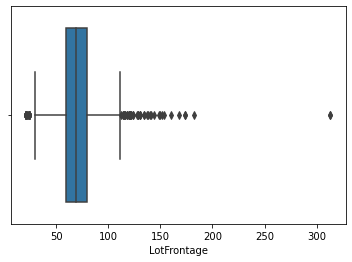

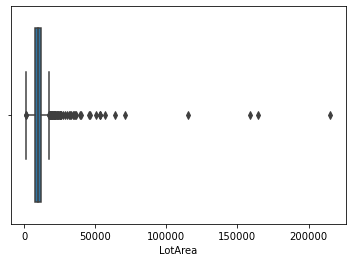

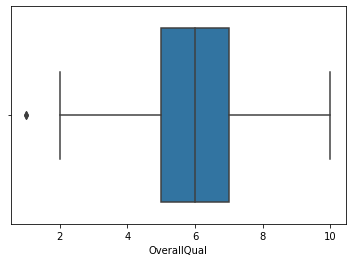

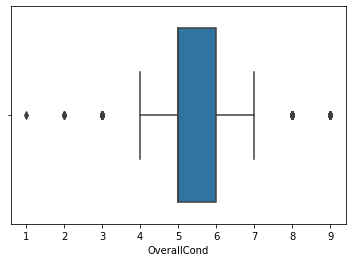

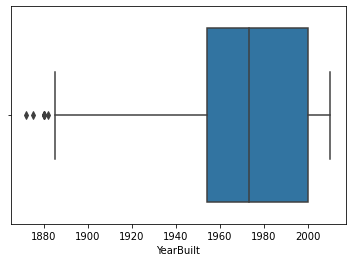

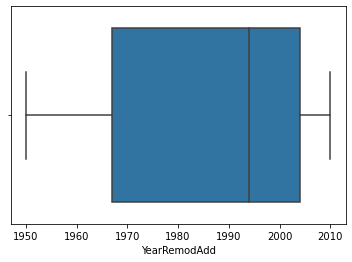

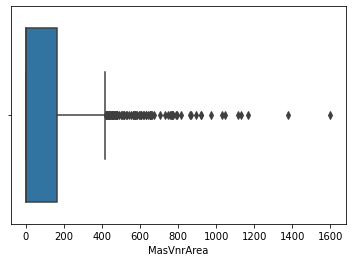

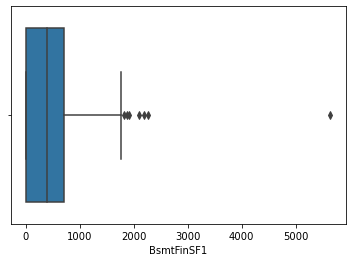

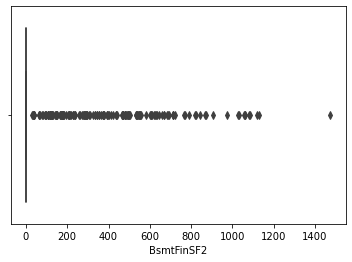

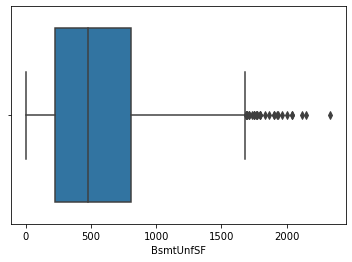

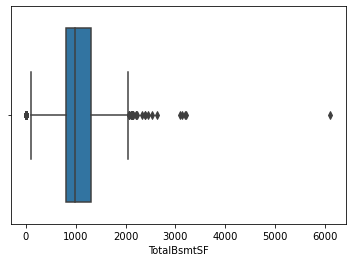

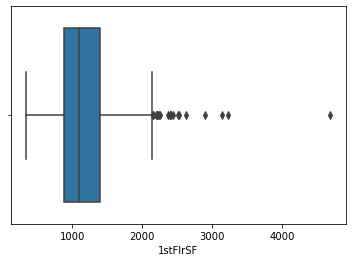

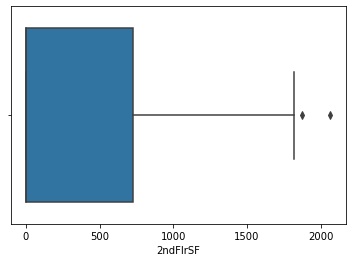

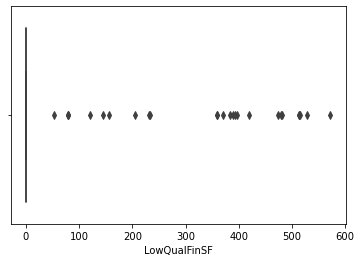

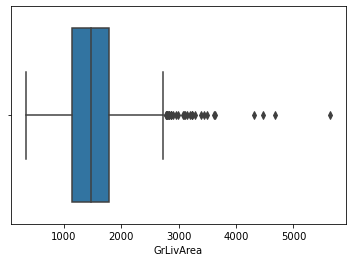

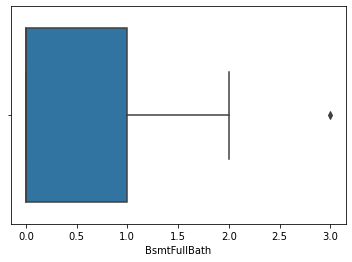

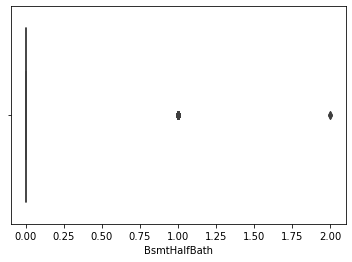

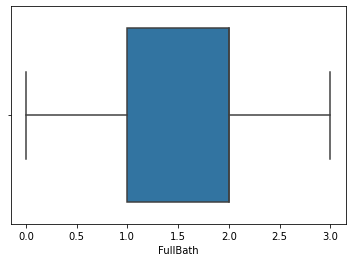

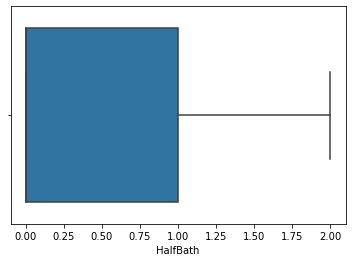

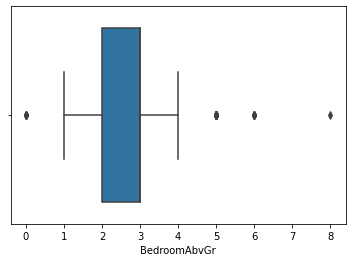

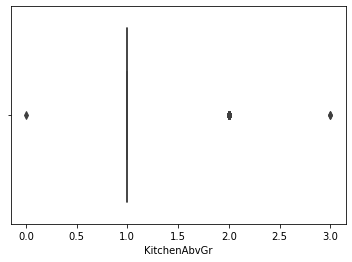

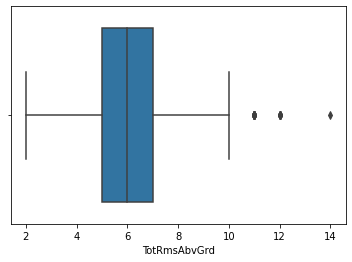

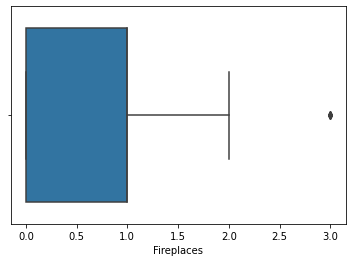

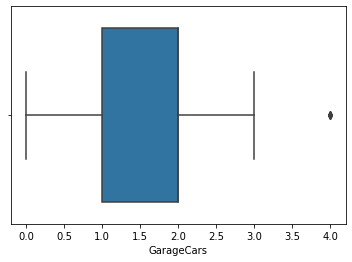

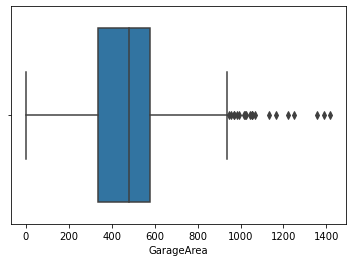

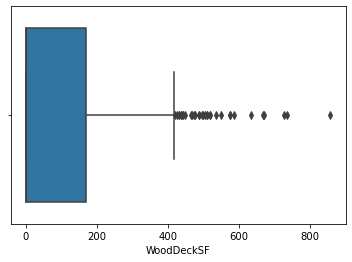

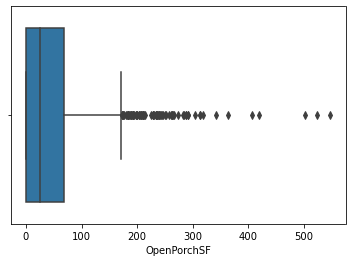

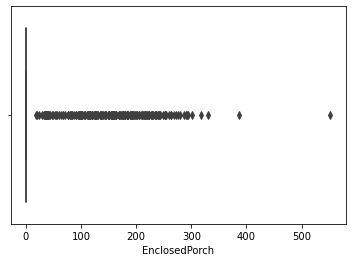

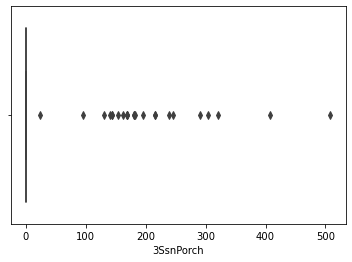

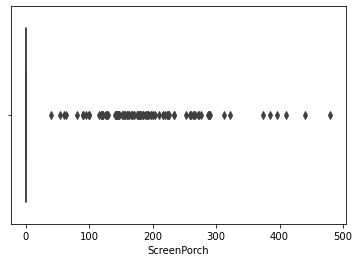

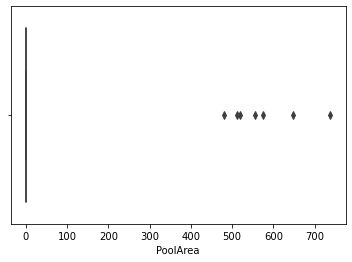

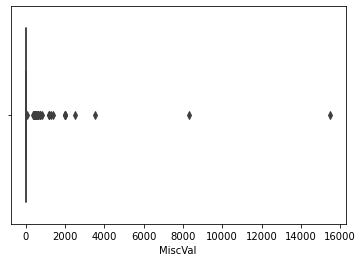

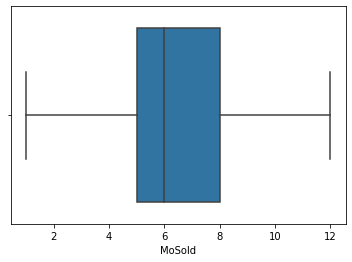

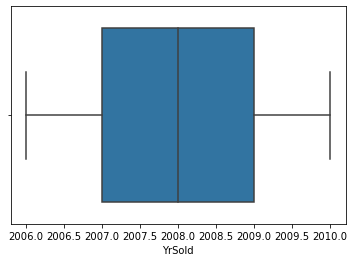

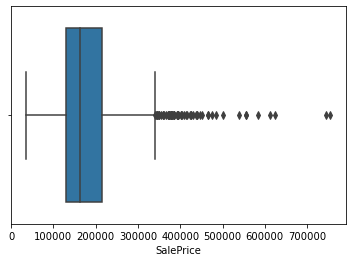

In [47]:
for c in col:
    sns.boxplot(price[c])  # Boxplots for all neumerical variables
    plt.show();

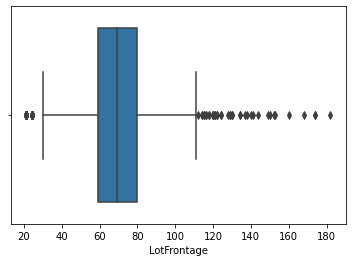

In [48]:
# Outlier Treatment dome on required variables
Q1 = price.LotFrontage.quantile(0.05)
Q3 = price.LotFrontage.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.LotFrontage >= Q1 - 1.5*IQR) & (price.LotFrontage <= Q3 + 1.5*IQR)]

sns.boxplot(price.LotFrontage)

In [49]:
# Outlier Treatment done on required variables

Q1 = price.LotArea.quantile(0.05)
Q3 = price.LotArea.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.LotArea >= Q1 - 1.5*IQR) & (price.LotArea <= Q3 + 1.5*IQR)]

Q1 = price.MasVnrArea.quantile(0.05)
Q3 = price.MasVnrArea.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.MasVnrArea >= Q1 - 1.5*IQR) & (price.MasVnrArea <= Q3 + 1.5*IQR)]

Q1 = price.BsmtFinSF1.quantile(0.05)
Q3 = price.BsmtFinSF1.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.BsmtFinSF1 >= Q1 - 1.5*IQR) & (price.BsmtFinSF1 <= Q3 + 1.5*IQR)]

Q1 = price.BsmtFinSF2.quantile(0.05)
Q3 = price.BsmtFinSF2.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.BsmtFinSF2 >= Q1 - 1.5*IQR) & (price.BsmtFinSF2 <= Q3 + 1.5*IQR)]

Q1 = price.BsmtUnfSF.quantile(0.05)
Q3 = price.BsmtUnfSF.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.BsmtUnfSF >= Q1 - 1.5*IQR) & (price.BsmtUnfSF <= Q3 + 1.5*IQR)]

Q1 = price.TotalBsmtSF.quantile(0.05)
Q3 = price.TotalBsmtSF.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.TotalBsmtSF >= Q1 - 1.5*IQR) & (price.TotalBsmtSF <= Q3 + 1.5*IQR)]

Q1 = price.LowQualFinSF.quantile(0.05)
Q3 = price.LowQualFinSF.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.LowQualFinSF >= Q1 - 1.5*IQR) & (price.LowQualFinSF <= Q3 + 1.5*IQR)]

Q1 = price.GrLivArea.quantile(0.05)
Q3 = price.GrLivArea.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.GrLivArea >= Q1 - 1.5*IQR) & (price.GrLivArea <= Q3 + 1.5*IQR)]

Q1 = price.WoodDeckSF.quantile(0.05)
Q3 = price.WoodDeckSF.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.WoodDeckSF >= Q1 - 1.5*IQR) & (price.WoodDeckSF <= Q3 + 1.5*IQR)]

Q1 = price.OpenPorchSF.quantile(0.05)
Q3 = price.OpenPorchSF.quantile(0.95)
IQR = Q3 - Q1
price = price[(price.OpenPorchSF >= Q1 - 1.5*IQR) & (price.OpenPorchSF <= Q3 + 1.5*IQR)]


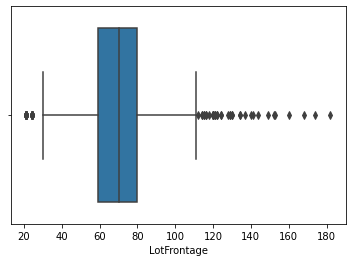

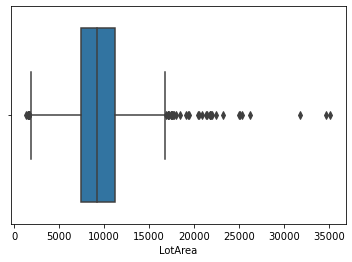

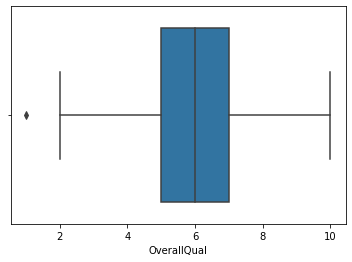

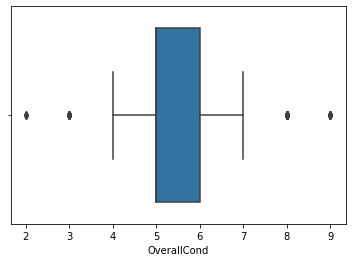

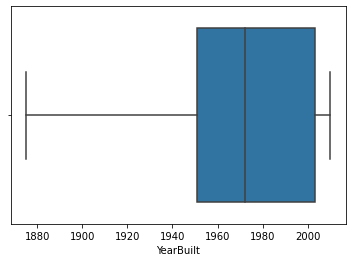

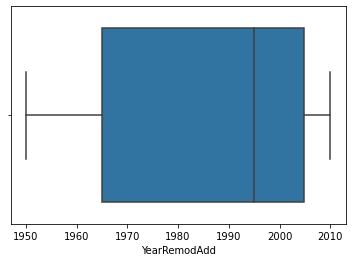

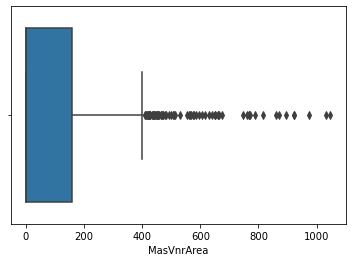

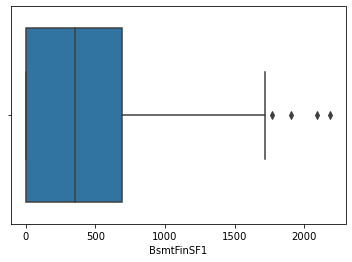

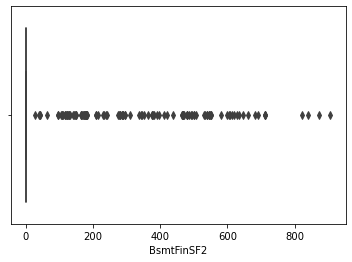

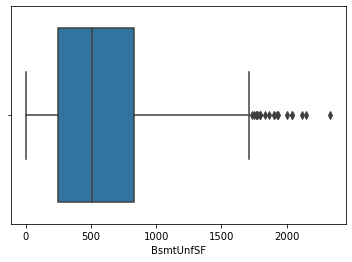

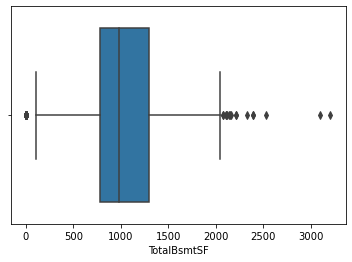

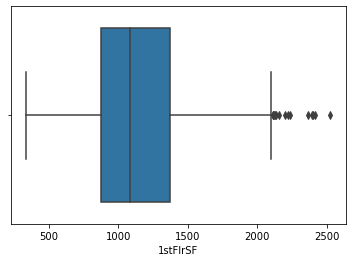

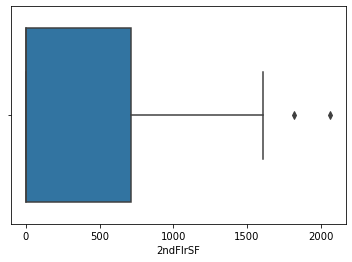

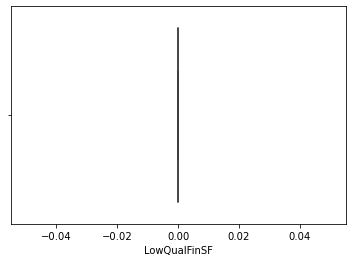

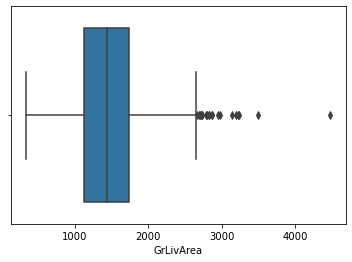

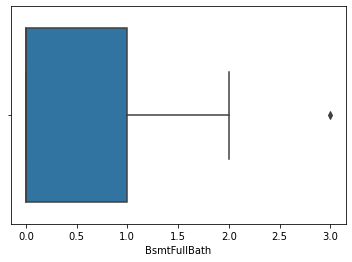

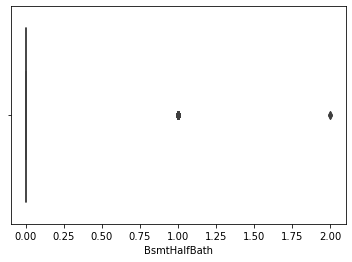

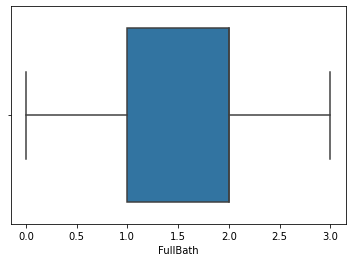

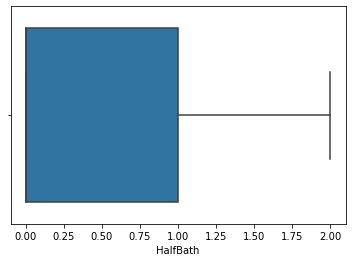

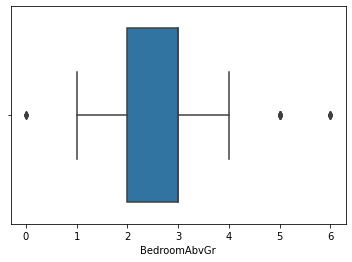

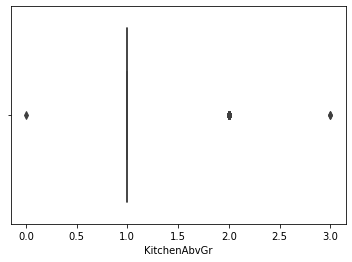

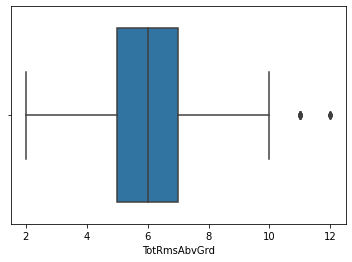

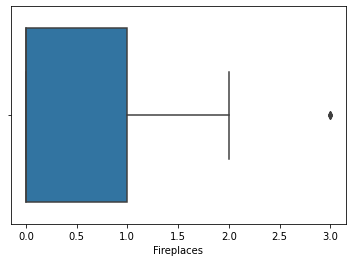

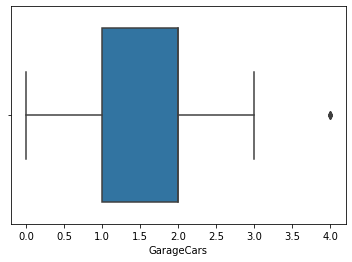

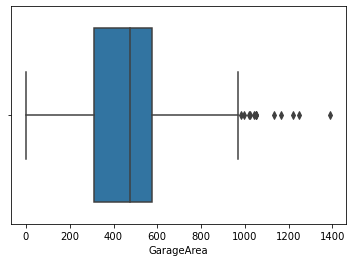

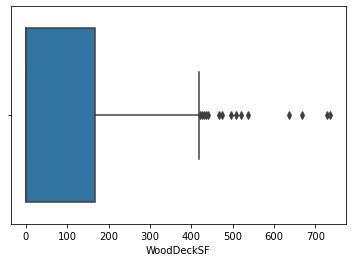

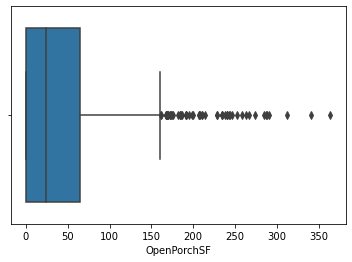

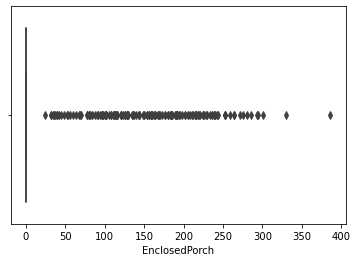

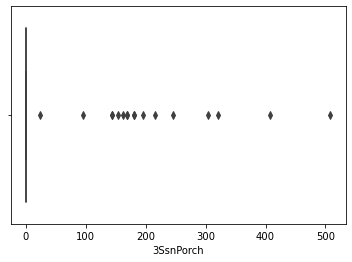

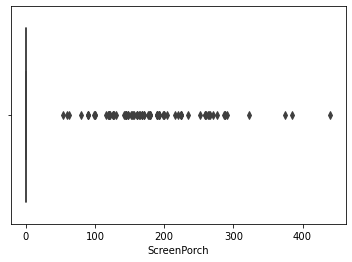

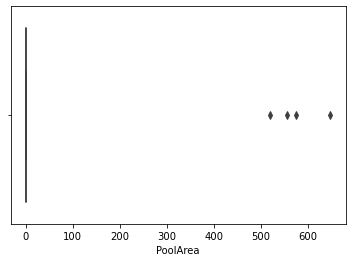

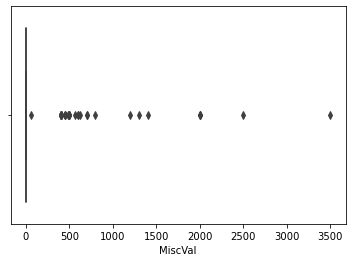

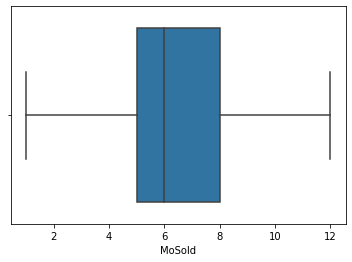

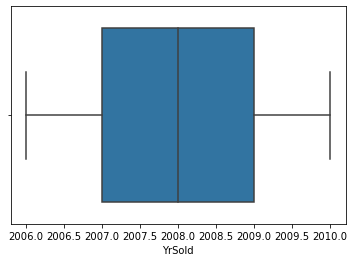

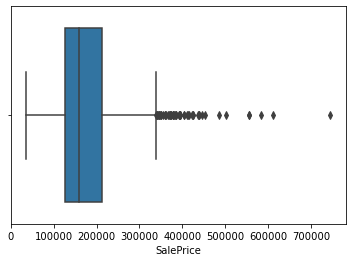

In [50]:
for c in col:
    sns.boxplot(price[c]) # box plots for all the num variables after outlier treatment
    plt.show();

In [51]:
price.Age = 2021 - price.YearBuilt # Converted year to Age of the building
price.Age

0        18
1        45
2        20
3       106
4        21
       ... 
1454     17
1455     22
1456     43
1457     80
1459     56
Name: YearBuilt, Length: 1146, dtype: int64

In [52]:
price.remod_Age = 2021 -price.YearRemodAdd # converted remodified year to Age after remodification.

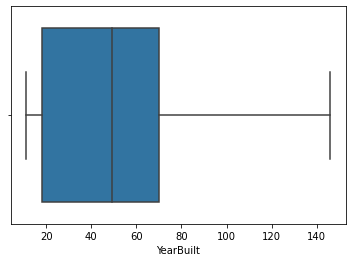

In [53]:
sns.boxplot(price.Age)

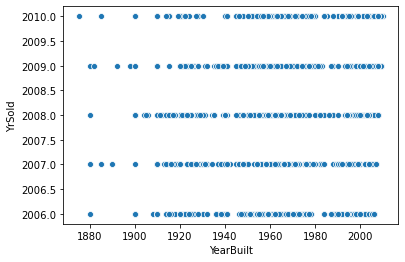

In [54]:
sns.scatterplot(data = price, x = 'YearBuilt', y = 'YrSold')

In [55]:
price = price.drop(['YearBuilt', 'YrSold', 'YearRemodAdd', 'MoSold'],1) # dropped year built, yearremod and yearsold after making modifications

In [56]:
price.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrType', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'MSZoning_RL',
       'MSZoning_RM', 'LotShape_Others', 'LotShape_Reg', 'LotConfig_Inside',
       'LotConfig_Others', 'Neighborhood_Edwards', 'Neighborhood_NAmes',
       'Neighborhood_OldTown', 'Neighborhood_Others', 'BldgType_Others',
       'BldgType_TwnhsE', 'HouseStyle_1Story', 'HouseStyle_2Story',
       'HouseStyle_Others', 'RoofStyle_Hip', 'RoofStyle_Others',
       'Exterior1st_MetalSd', 'Exterior1st_Others', 'Exterior1st_VinylSd',
       'Exterior1st_WdSdng', 'Exterior2nd_MetalSd'

In [57]:
price = price.drop(['Id','MasVnrType'], 1) # Dropped Masonry Veneer Type, since it is having high percentage of None values

In [58]:
col = price.columns
col

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_Others',
       'LotShape_Reg', 'LotConfig_Inside', 'LotConfig_Others',
       'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_OldTown',
       'Neighborhood_Others', 'BldgType_Others', 'BldgType_TwnhsE',
       'HouseStyle_1Story', 'HouseStyle_2Story', 'HouseStyle_Others',
       'RoofStyle_Hip', 'RoofStyle_Others', 'Exterior1st_MetalSd',
       'Exterior1st_Others', 'Exterior1st_VinylSd', 'Exterior1st_WdSdng',
       'Exterior2nd_MetalSd', 'Exterior2nd_Other

In [59]:
# final set of columns that are converted into all numericals....

col = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'SalePrice', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_Others', 'LotShape_Reg', 'LotConfig_Inside',
       'LotConfig_Others', 'Neighborhood_Edwards', 'Neighborhood_NAmes',
       'Neighborhood_OldTown', 'Neighborhood_Others', 'BldgType_Others',
       'BldgType_TwnhsE', 'HouseStyle_1Story', 'HouseStyle_2Story',
       'HouseStyle_Others', 'RoofStyle_Hip', 'RoofStyle_Others',
       'Exterior1st_MetalSd', 'Exterior1st_Others', 'Exterior1st_VinylSd',
       'Exterior1st_WdSdng', 'Exterior2nd_MetalSd', 'Exterior2nd_Others',
       'Exterior2nd_Plywood', 'Exterior2nd_VinylSd', 'Exterior2nd_WdSdng',
       'ExterQual_Others', 'ExterQual_TA', 'Foundation_Others',
       'Foundation_PConc', 'BsmtQual_Others', 'BsmtQual_TA', 'BsmtExposure_Gd',
       'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_BLQ',
       'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec',
       'BsmtFinType1_Unf', 'HeatingQC_Gd', 'HeatingQC_Others', 'HeatingQC_TA',
       'KitchenQual_Others', 'KitchenQual_TA', 'GarageType_Detchd',
       'GarageType_Others', 'GarageFinish_RFn', 'GarageFinish_Unf',
       'SaleCondition_Others', 'SaleCondition_Partial',
       'MSSubClass_1_story_Newer', 'MSSubClass_2_story_Newer',
       'MSSubClass_Others']

In [60]:
n_cols = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'SalePrice']

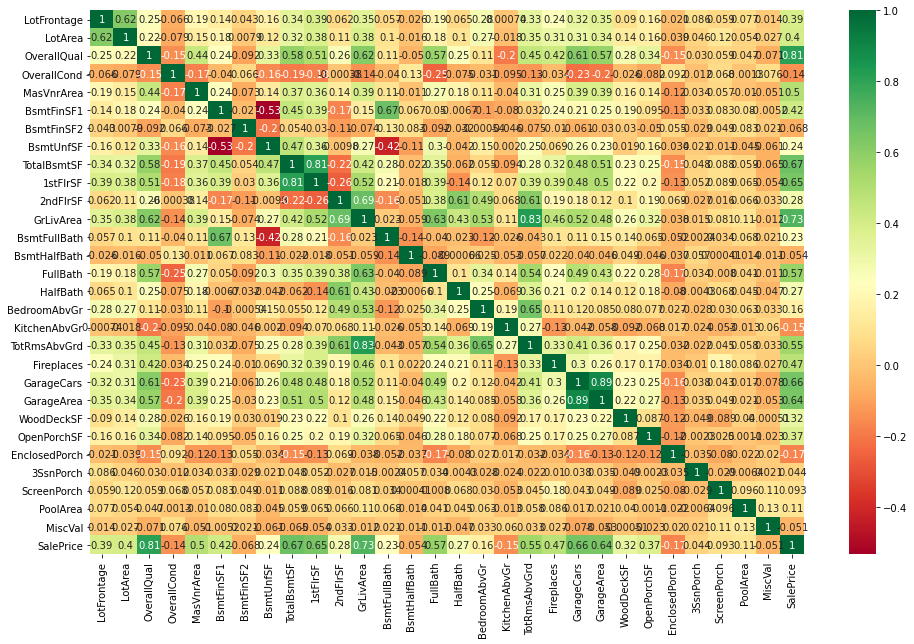

In [61]:
num_df = price[n_cols]
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(num_df.corr(), annot = True, cmap="RdYlGn")
plt.show()

# Preparing the data for modelling:


In [62]:
## Splitting the Data into Training and Testing Sets and print their shapes

df_train, df_test = train_test_split(price, train_size = 0.7, random_state = 100) # Create train and test sets
print(df_train.shape)
print(df_test.shape)

(802, 85)
(344, 85)


In [63]:
from sklearn.preprocessing import MinMaxScaler  # import the MinMaxScaler to scale the numeric values between 0 and 1.

# Instantiate the object.
scaler = MinMaxScaler()

#fit and transform the training set
df_train[col] = scaler.fit_transform(df_train[col])

In [64]:
df_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,KitchenQual_TA,GarageType_Detchd,GarageType_Others,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Others,SaleCondition_Partial,MSSubClass_1_story_Newer,MSSubClass_2_story_Newer,MSSubClass_Others
505,0.242236,0.186091,0.375,0.428571,0.343840,0.000000,0.0,0.410959,0.299439,0.288377,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
795,0.304348,0.209854,0.500,0.571429,0.124164,0.000000,0.0,0.278253,0.202745,0.253065,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
474,0.124224,0.119114,0.750,0.428571,0.000000,0.546618,0.0,0.127568,0.466001,0.627759,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
642,0.335404,0.371235,0.750,0.714286,0.000000,0.644424,0.0,0.232021,0.608858,0.798431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
216,0.273292,0.211332,0.625,0.428571,0.254059,0.432358,0.0,0.209760,0.447910,0.521824,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [65]:
y_train = df_train.pop("SalePrice")    # pop out target variable from training set and assign it to y_train and the rest to X_train
X_train = df_train      # y_train in small letters as it is dependent variable, X_train in caps bez they are dependant variables

In [66]:
y_train.head()

505    0.122472
795    0.188234
474    0.301372
642    0.434309
216    0.243388
Name: SalePrice, dtype: float64

# Model Building through RFE (Recursive feature elimination)


In [67]:
# import the required scikit learn libraries

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [68]:
# Instantiate Linear Regression
lm = LinearRegression()

# create a model and fit
lm.fit(X_train, y_train)

# assign number of variable for automatic selection
rfe = RFE(lm, 30)

# fit the rfe model
rfe = rfe.fit(X_train, y_train)

In [69]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_)) # rfe.support_ : tells you weather it is required or not.


[('LotFrontage', True, 1),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('MasVnrArea', True, 1),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', False, 3),
 ('BsmtUnfSF', False, 2),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', False, 18),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 46),
 ('BsmtHalfBath', True, 1),
 ('FullBath', True, 1),
 ('HalfBath', True, 1),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', True, 1),
 ('Fireplaces', False, 31),
 ('GarageCars', True, 1),
 ('GarageArea', False, 44),
 ('WoodDeckSF', False, 39),
 ('OpenPorchSF', False, 19),
 ('EnclosedPorch', False, 52),
 ('3SsnPorch', False, 35),
 ('ScreenPorch', False, 54),
 ('PoolArea', True, 1),
 ('MiscVal', True, 1),
 ('MSZoning_RL', False, 28),
 ('MSZoning_RM', False, 16),
 ('LotShape_Others', False, 5),
 ('LotShape_Reg', False, 30),
 ('LotConfig_Inside', False, 43),
 ('LotConfig_Others', False, 47),
 ('Neighbo

In [70]:
main_col = X_train.columns[rfe.support_] 

# columns important less collinearity are the variables we shouldn't drop but rest we drop.
main_col

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'PoolArea', 'MiscVal',
       'Neighborhood_OldTown', 'HouseStyle_2Story', 'Exterior2nd_Others',
       'Exterior2nd_VinylSd', 'ExterQual_Others', 'BsmtQual_Others',
       'BsmtExposure_Gd', 'BsmtFinType1_GLQ', 'KitchenQual_Others',
       'SaleCondition_Partial', 'MSSubClass_2_story_Newer'],
      dtype='object')

In [71]:
# Create a new dataframe with less collinear columns
X_train_rfe = X_train[main_col]   

# add a constant
X_train_rfe = sm.add_constant(X_train_rfe)

# fit the model
lm = sm.OLS(y_train, X_train_rfe).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     252.7
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:51:11   Log-Likelihood:                 1530.6
No. Observations:                 802   AIC:                            -3001.
Df Residuals:                     772   BIC:                            -2860.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0710      0.012     -5.845      0.000      -0.095      -0.047
LotFrontage                  0.0347      0.013      2.664      0.008       0.009       0.060
LotArea                      0.0366      0.016      2.256      0.024       0.005       0.068
OverallQual                  0.1398      0.014     10.254      0.000       0.113       0.167
OverallCond                  0.0689      0.009      7.420      0.000       0.051       0.087
MasVnrArea                   0.0206      0.010      2.145      0.032       0.002       0.039
BsmtFinSF1                   0.0719      0.009      7.815      0.000       0.054       0.090
TotalBsmtSF                  0.1153      0.019      6.046      0.000       0.078       0.153
1stFlrSF                     0.1127      0.015      7.770      0.000       0.084       0.141
2ndFlrSF                     0.1043      0.012      8.545      0.000       0.080       0.128
GrLivArea                    0.1114      0.009     11.775      0.000       0.093       0.130
BsmtHalfBath                -0.0196      0.011     -1.757      0.079      -0.041       0.002
FullBath                     0.0472      0.011      4.175      0.000       0.025       0.069
HalfBath                     0.0152      0.008      1.971      0.049    5.91e-05       0.030
BedroomAbvGr                -0.0580      0.015     -3.881      0.000      -0.087      -0.029
KitchenAbvGr                -0.0672      0.013     -5.056      0.000      -0.093      -0.041
TotRmsAbvGrd                 0.0157      0.016      0.977      0.329      -0.016       0.047
GarageCars                   0.0263      0.010      2.642      0.008       0.007       0.046
PoolArea                     0.0863      0.021      4.027      0.000       0.044       0.128
MiscVal                     -0.0305      0.022     -1.392      0.164      -0.074       0.013
Neighborhood_OldTown        -0.0242      0.005     -4.686      0.000      -0.034      -0.014
HouseStyle_2Story           -0.0116      0.006     -1.971      0.049      -0.023   -4.65e-05
Exterior2nd_Others           0.0104      0.004      2.535      0.011       0.002       0.019
Exterior2nd_VinylSd          0.0149      0.004      4.189      0.000       0.008       0.022
ExterQual_Others             0.0348      0.008      4.586      0.000       0.020       0.050
BsmtQual_Others              0.0338      0.005      6.696      0.000       0.024       0.044
BsmtExposure_Gd              0.0158      0.005      3.012      0.003       0.005       0.026
BsmtFinType1_GLQ             0.0133      0.004      3.351      0.001       0.005       0.021
KitchenQual_Others           0.0238      0.005      4.750      0.000       0.014       0.034
SaleCondition_Partial        0.0299      0.005      5.989      0.000       0.020       0.040
MSSubClass_2_s

In [72]:
y_train_pred = lm.predict(X_train_rfe) # predicted values of training set target values


In [73]:
res = y_train - y_train_pred # magnitude of residues.

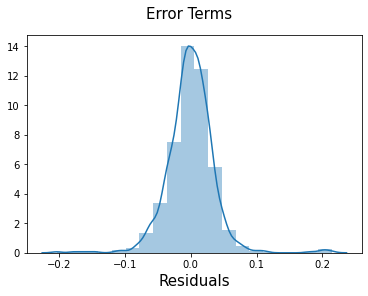

In [74]:
fig = plt.figure()
sns.distplot(res, bins = 20) # Ploted the distribution plot for residues and found it is normally distributed & with mean zero.
fig.suptitle('Error Terms', fontsize = 15)
plt.xlabel('Residuals', fontsize = 15)
plt.show()

In [75]:
df_test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,KitchenQual_TA,GarageType_Detchd,GarageType_Others,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Others,SaleCondition_Partial,MSSubClass_1_story_Newer,MSSubClass_2_story_Newer,MSSubClass_Others
357,44.0,4224,5,5,0.0,874,0,268,1142,1142,...,1,0,0,0,0,0,0,0,0,1
930,73.0,8925,8,5,0.0,16,0,1450,1466,1466,...,0,0,0,0,0,0,0,1,0,0
909,149.0,12589,6,5,0.0,0,0,742,742,742,...,0,0,0,0,0,0,0,0,1,0
204,50.0,3500,5,7,0.0,312,0,408,720,720,...,1,1,0,0,1,0,0,0,0,0
1191,24.0,2645,8,5,456.0,0,0,776,776,764,...,0,1,0,0,1,0,0,0,0,1


In [76]:
df_test[col] = scaler.transform(df_test[col]) # Only transform test set


In [77]:
df_test.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,KitchenQual_TA,GarageType_Detchd,GarageType_Others,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Others,SaleCondition_Partial,MSSubClass_1_story_Newer,MSSubClass_2_story_Newer,MSSubClass_Others
357,0.142857,0.086424,0.375,0.428571,0.00000,0.399452,0.0,0.114726,0.356207,0.377636,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
930,0.322981,0.225372,0.750,0.428571,0.00000,0.007313,0.0,0.620719,0.457268,0.536538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
909,0.795031,0.333668,0.500,0.428571,0.00000,0.000000,0.0,0.317637,0.231441,0.181462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
204,0.180124,0.065025,0.375,0.714286,0.00000,0.142596,0.0,0.174658,0.224579,0.170672,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1191,0.018634,0.039754,0.750,0.428571,0.43553,0.000000,0.0,0.332192,0.242046,0.192251,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [78]:
df_test.describe() 
# we can observe some max values are even above 1, which indicates the value in test set is higher to training set of "BsmtFinSF2"

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,KitchenQual_TA,GarageType_Detchd,GarageType_Others,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Others,SaleCondition_Partial,MSSubClass_1_story_Newer,MSSubClass_2_story_Newer,MSSubClass_Others
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,...,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.300430,0.240417,0.513808,0.507890,0.092737,0.197261,0.036534,0.256271,0.331289,0.382305,...,0.502907,0.293605,0.055233,0.281977,0.476744,0.087209,0.098837,0.401163,0.194767,0.313953
std,0.132779,0.112922,0.181080,0.150948,0.150154,0.193165,0.133618,0.198472,0.127306,0.179209,...,0.500720,0.456076,0.228766,0.450618,0.500186,0.282553,0.298878,0.490848,0.396598,0.464774
min,0.000000,0.005645,-0.125000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018637,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.236025,0.184960,0.375000,0.428571,0.000000,0.000000,0.000000,0.103382,0.248752,0.241295,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.304348,0.232569,0.500000,0.428571,0.000000,0.174817,0.000000,0.210830,0.314099,0.353850,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.378882,0.282195,0.625000,0.571429,0.153295,0.328154,0.000000,0.362800,0.409155,0.489701,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,0.795031,0.985724,1.000000,1.000000,0.853868,0.775137,1.038991,0.828339,0.787274,1.055419,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [79]:
y_test = df_test.pop('SalePrice') # pop out target variable from training set and assign it to y_test and the rest to X_test
X_test = df_test

In [80]:
X_test_sm = sm.add_constant(X_test) # add constant
X_test_sm.head()

,const,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,KitchenQual_TA,GarageType_Detchd,GarageType_Others,GarageFinish_RFn,GarageFinish_Unf,SaleCondition_Others,SaleCondition_Partial,MSSubClass_1_story_Newer,MSSubClass_2_story_Newer,MSSubClass_Others
357,1.0,0.142857,0.086424,0.375,0.428571,0.00000,0.399452,0.0,0.114726,0.356207,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
930,1.0,0.322981,0.225372,0.750,0.428571,0.00000,0.007313,0.0,0.620719,0.457268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
909,1.0,0.795031,0.333668,0.500,0.428571,0.00000,0.000000,0.0,0.317637,0.231441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
204,1.0,0.180124,0.065025,0.375,0.714286,0.00000,0.142596,0.0,0.174658,0.224579,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1191,1.0,0.018634,0.039754,0.750,0.428571,0.43553,0.000000,0.0,0.332192,0.242046,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [81]:
# creating X_test_new by dropping variables from X_test 
X_test_new = X_test_sm[main_col]

# Add a constant 
X_test_new = sm.add_constant(X_test_new)

In [82]:
X_test_new.head()

,const,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,HouseStyle_2Story,Exterior2nd_Others,Exterior2nd_VinylSd,ExterQual_Others,BsmtQual_Others,BsmtExposure_Gd,BsmtFinType1_GLQ,KitchenQual_Others,SaleCondition_Partial,MSSubClass_2_story_Newer
357,1.0,0.142857,0.086424,0.375,0.428571,0.00000,0.399452,0.356207,0.377636,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
930,1.0,0.322981,0.225372,0.750,0.428571,0.00000,0.007313,0.457268,0.536538,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
909,1.0,0.795031,0.333668,0.500,0.428571,0.00000,0.000000,0.231441,0.181462,0.359322,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
204,1.0,0.180124,0.065025,0.375,0.714286,0.00000,0.142596,0.224579,0.170672,0.273123,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1191,1.0,0.018634,0.039754,0.750,0.428571,0.43553,0.000000,0.242046,0.192251,0.327845,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
# making predictions
y_test_pred = lm.predict(X_test_new)

Text(0, 0.5, 'y_pred')

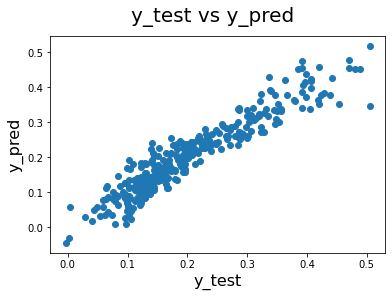

In [84]:
# plotting y_test vs y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)
plt.xlabel("y_test", fontsize = 16)
plt.ylabel('y_pred', fontsize = 16)

In [85]:
# lets see the R squared value for the test set, import required libraries.
from sklearn.metrics import r2_score

In [86]:
r2_score(y_true = y_test, y_pred = y_test_pred)
#The R squared for the test set is approximately equal to R squared on training set

0.8841646620796615

In [87]:

y_pred_train = lm.predict(X_train_rfe)
y_pred_test = lm.predict(X_test_new)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9046944110959771
0.8841646620796615
1.0329238434074401
0.41247221309605675
0.0012879349668421948
0.0011990471310931881


# Ridge Regression

In [88]:
from sklearn.model_selection import GridSearchCV
import os

In [89]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.00005, 0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    1.0s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [5e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20,
                                   50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [90]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 3.0}


- **`Note:`** Optimal value of 'alpha' using Ridge Regression is **`3`**

In [91]:
#Fitting Ridge model for alpha = 3.0 and printing coefficients which have been penalised
alpha = 3.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_) 

[ 0.02761115  0.01826666  0.10960461  0.05216459  0.03268786  0.08262657
  0.01003279  0.01488916  0.06996775  0.09193717  0.06738442  0.
  0.08088378  0.00513188 -0.0131941   0.04889081  0.02064261 -0.0260439
 -0.03509164  0.02851831  0.0099016   0.0153501   0.0136217   0.00669949
  0.01145117  0.00082429  0.00768219  0.00261429  0.05234322 -0.01751041
 -0.0014321  -0.00821397  0.00749282 -0.00482011  0.00133886  0.00154082
 -0.00402732  0.00130886 -0.0125214   0.00907301 -0.00977274 -0.00731984
 -0.00332143 -0.00715137 -0.00416856  0.0051163  -0.00404906  0.00225509
  0.00335504  0.00031012 -0.00055744  0.00681946  0.01019104 -0.00546999
  0.0107255   0.00251557  0.02258488 -0.00857233 -0.00070023  0.0051445
  0.0362698   0.00402706  0.01540854 -0.01083118 -0.00846664 -0.00119894
  0.01409522 -0.00212489 -0.00563387  0.00206198 -0.01006385 -0.00624126
 -0.01043841  0.02636254  0.00145984  0.00456469  0.00519374 -0.00453732
 -0.00083037 -0.00869694  0.02534645  0.00616045  0.01602987 

In [92]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9077897089384209
0.8960990715616689
0.9993769446297883
0.369975576237074
0.0012461059159972422
0.0010755103960380058


# Lasso Regression

In [93]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    1.3s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [5e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20,
                                   50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [94]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [95]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

- **`Note:`** Optimal value of Alpha using Lasso Regression is **`0.0001`**.

In [96]:
lasso.coef_

array([ 2.95624364e-02,  1.18351164e-02,  1.39095456e-01,  5.77992221e-02,
        2.63931619e-02,  8.32984109e-02,  2.88389359e-03,  0.00000000e+00,
        9.34650428e-02,  1.08148886e-01,  7.79123774e-02,  0.00000000e+00,
        1.38636249e-01,  0.00000000e+00, -1.09948357e-02,  4.07285367e-02,
        1.63015156e-02, -3.23040645e-02, -4.20958675e-02,  5.41570552e-04,
        0.00000000e+00,  1.42152807e-02,  1.55903878e-03,  0.00000000e+00,
        5.22565719e-03, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        6.25839858e-02, -1.12165340e-03,  0.00000000e+00, -6.98657992e-03,
        5.61641344e-03, -3.81867476e-03,  8.99155617e-04,  0.00000000e+00,
       -2.90428510e-03,  0.00000000e+00, -1.35766817e-02,  7.31732391e-03,
       -6.43813346e-03, -5.20150751e-03,  9.31373286e-04, -4.35980897e-03,
       -0.00000000e+00,  7.92064125e-04, -2.80669344e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.60606819e-03,  6.91140903e-03,
        9.59095537e-03, -

In [97]:
# Lets calculate some metrics such as R2 score , RSS and RMSE for training sets and test sets respectively

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9106840876749913
0.8935359938664899
0.9680076110656703
0.37910231034298825
0.0012069920337477186
0.0011020415998342682


In [98]:
from sklearn.model_selection import GridSearchCV


In [99]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.904694,0.907790,0.910684
1,R2 Score (Test),0.884165,0.896099,0.893536
2,RSS (Train),1.032924,0.999377,0.968008
3,RSS (Test),0.412472,0.369976,0.379102
4,MSE (Train),0.035888,0.035300,0.034742
5,MSE (Test),0.034627,0.032795,0.033197


**`Inference:`** The change in R2 score value between training and test set is **` minimum with Ridge Regression`** as its aplha value is neither too low nor too high.

## Lets observe the coefficients after regularization

In [100]:
betas = pd.DataFrame(index=X_test.columns) 
# creating the dataframe with name 'betas' and taking columns as beta values of Ridge and Lasso 

betas.rows = X_test.columns 
# Taking all the features in X_test and assigning them as rows to betas data frame

betas['Ridge'] = ridge.coef_  # Assigning beta value to its corresponsing feature of Ridge
betas['Lasso'] = lasso.coef_  # Assigning beta value to its corresponsing feature of Lasso

pd.set_option('display.max_rows', None) # we are setting maximum number of rows to be displayed set_option
betas

,Ridge,Lasso
LotFrontage,0.027611,0.029562
LotArea,0.018267,0.011835
OverallQual,0.109605,0.139095
OverallCond,0.052165,0.057799
MasVnrArea,0.032688,0.026393
BsmtFinSF1,0.082627,0.083298
BsmtFinSF2,0.010033,0.002884
BsmtUnfSF,0.014889,0.000000
TotalBsmtSF,0.069968,0.093465
1stFlrSF,0.091937,0.108149


In [101]:
betas.sort_values('Ridge', ascending = False).head(20)
# sorted values on Ridge column in the descending values of beta.

,Ridge,Lasso
OverallQual,0.109605,0.139095
1stFlrSF,0.091937,0.108149
BsmtFinSF1,0.082627,0.083298
GrLivArea,0.080884,0.138636
TotalBsmtSF,0.069968,0.093465
2ndFlrSF,0.067384,0.077912
PoolArea,0.052343,0.062584
OverallCond,0.052165,0.057799
FullBath,0.048891,0.040729
BsmtQual_Others,0.036270,0.034373


- **`Inference:`** What we can infer is **`Overall Quality`** (i.e., Rates the overall material and finish of the house) , **`First Floor square feet`**, **`BsmtFinSF1: Type 1 finished square feet`** ,  **`Above grade (ground) living area square feet`**, **`Total Basement Square Feet`** (i.e., Total square feet of basement area) are the top 5 most prominant features which effect **`Sale Price`** respectively using **` Ridge `** Regression.

In [102]:
betas.sort_values('Lasso', ascending = False).head(20)
# sorted values on Ridge column in the descending values of beta.

,Ridge,Lasso
OverallQual,0.109605,0.139095
GrLivArea,0.080884,0.138636
1stFlrSF,0.091937,0.108149
TotalBsmtSF,0.069968,0.093465
BsmtFinSF1,0.082627,0.083298
2ndFlrSF,0.067384,0.077912
PoolArea,0.052343,0.062584
OverallCond,0.052165,0.057799
FullBath,0.048891,0.040729
BsmtQual_Others,0.036270,0.034373


- **`Inference:`** What we can infer is **`Overall Quality`** (i.e., Rates the overall material and finish of the house) , **`Above grade (ground) living area square feet`**, **`First Floor square feet`**, **`Total Basement Square Feet`** (i.e., Total square feet of basement area) **`BsmtFinSF1: Type 1 finished square feet`** ,    are the top 5 most prominant features which effect **`Sale Price`** respectively using **`Lasso`** Regression.

### Results after Doubling Alpha value of Ridge and Lasso

In [103]:
#Fitting Ridge model for double the alpha = 6.0 and printing coefficients which have been penalised
alpha = 6.0
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 0.02364597  0.01772359  0.09284274  0.04238603  0.03291192  0.07018046
  0.00757477  0.01562083  0.06133822  0.08074288  0.05073049  0.
  0.06671451  0.00812853 -0.01063322  0.04464501  0.01916763 -0.01307641
 -0.02428629  0.03283241  0.01639991  0.01796409  0.01785727  0.00797531
  0.01292448  0.00107657  0.00576248  0.00392069  0.03759768 -0.01260669
  0.00053761 -0.00712578  0.00643947 -0.00529066  0.00051756  0.00167652
 -0.00384082  0.00176487 -0.00982889  0.01087407 -0.01109583 -0.00757229
 -0.00473965 -0.00307411 -0.00340532  0.0081327  -0.0014788   0.00386839
  0.00476942  0.00193831  0.00096361  0.00591873  0.00899219 -0.00630867
  0.00811876  0.00296877  0.02147796 -0.0106378  -0.00050294  0.00531231
  0.03784594  0.00148788  0.0163478  -0.01086889 -0.00892386 -0.00144844
  0.01483087 -0.00232542 -0.0057313  -0.00137155 -0.01014415 -0.00811721
 -0.01101305  0.02760364 -0.0013097   0.00317158  0.0040806  -0.00520646
 -0.00333652 -0.00803032  0.02478371  0.00398802  0.0124307

In [104]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9014553479156955
0.894558451248986
1.0680288737387191
0.3754614934133166
0.0013317068251106224
0.0010914578296898738


- We saw a slight reduction in R-squared values which is due to the increse in simplicity of the model

In [105]:
#Fitting Lasso model for alpha = 0.001 and printing coefficients which have been penalised

alpha = 0.0002

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0002)

In [106]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9069761753667536
0.8926576165978766
1.0081940374493277
0.38223007966125405
0.0012570997973183637
0.0011111339525036454


- We saw a slight reduction in R-squared values which is due to the increse in simplicity of the model

In [107]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.904694,0.901455,0.906976
1,R2 Score (Test),0.884165,0.894558,0.892658
2,RSS (Train),1.032924,1.068029,1.008194
3,RSS (Test),0.412472,0.375461,0.382230
4,MSE (Train),0.035888,0.036493,0.035456
5,MSE (Test),0.034627,0.033037,0.033334


## Lets observe the changes in the coefficients after doubling the alpha

In [108]:
betas = pd.DataFrame(index=X_test.columns)

betas.rows = X_test.columns

betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

pd.set_option('display.max_rows', None)
betas

,Ridge,Lasso
LotFrontage,0.023646,0.023187
LotArea,0.017724,0.009130
OverallQual,0.092843,0.143300
OverallCond,0.042386,0.049782
MasVnrArea,0.032912,0.024337
BsmtFinSF1,0.070180,0.078782
BsmtFinSF2,0.007575,0.000000
BsmtUnfSF,0.015621,0.000000
TotalBsmtSF,0.061338,0.085091
1stFlrSF,0.080743,0.057653


In [109]:
betas.sort_values('Ridge', ascending = False).head(20)


,Ridge,Lasso
OverallQual,0.092843,0.143300
1stFlrSF,0.080743,0.057653
BsmtFinSF1,0.070180,0.078782
GrLivArea,0.066715,0.233296
TotalBsmtSF,0.061338,0.085091
2ndFlrSF,0.050730,0.009114
FullBath,0.044645,0.031267
OverallCond,0.042386,0.049782
BsmtQual_Others,0.037846,0.034936
PoolArea,0.037598,0.040799


In [110]:
betas.sort_values('Lasso', ascending = False).head(20)

,Ridge,Lasso
GrLivArea,0.066715,0.233296
OverallQual,0.092843,0.143300
TotalBsmtSF,0.061338,0.085091
BsmtFinSF1,0.070180,0.078782
1stFlrSF,0.080743,0.057653
OverallCond,0.042386,0.049782
PoolArea,0.037598,0.040799
BsmtQual_Others,0.037846,0.034936
FullBath,0.044645,0.031267
SaleCondition_Partial,0.024784,0.026473


- **`Inference:`** We dont see much change in the order of importance for Ridge Regression, but with Lasso **`Above grade (ground) living area square feet`** is most prominant feature now and **`First Floor square feet`** is 5th prominant. 

### Resedual Analysis over all and for the final features

In [111]:
y_pred_test = lm.predict(X_test_new)


In [112]:
 # magnitude of residues.
res = y_test - y_pred_test

In [113]:
y_test['res'] = res

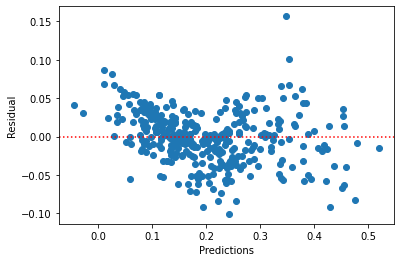

In [114]:
plt.scatter( y_pred_test , y_test['res'])
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

In [115]:
main_col 

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'PoolArea', 'MiscVal',
       'Neighborhood_OldTown', 'HouseStyle_2Story', 'Exterior2nd_Others',
       'Exterior2nd_VinylSd', 'ExterQual_Others', 'BsmtQual_Others',
       'BsmtExposure_Gd', 'BsmtFinType1_GLQ', 'KitchenQual_Others',
       'SaleCondition_Partial', 'MSSubClass_2_story_Newer'],
      dtype='object')

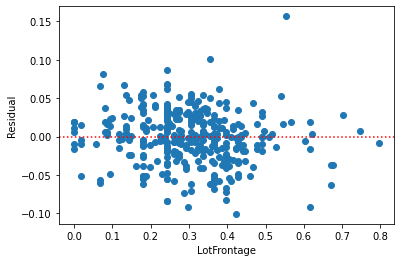

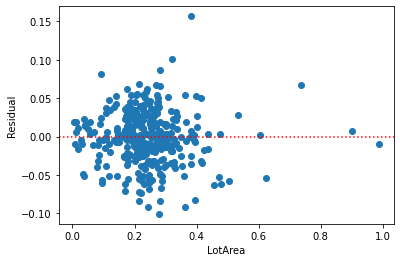

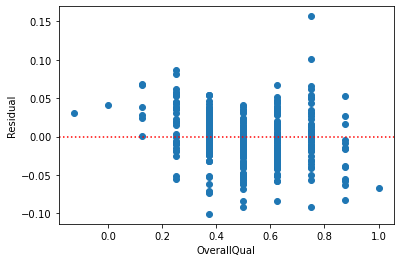

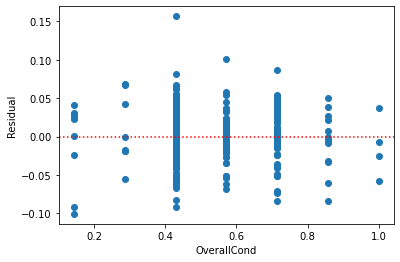

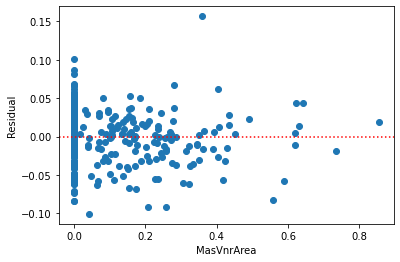

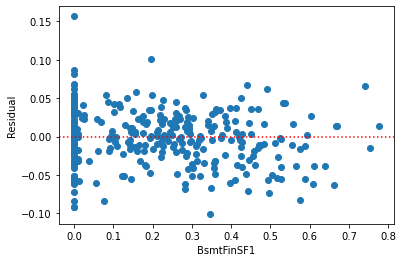

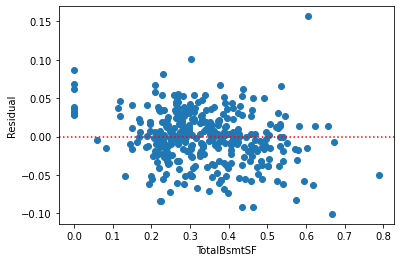

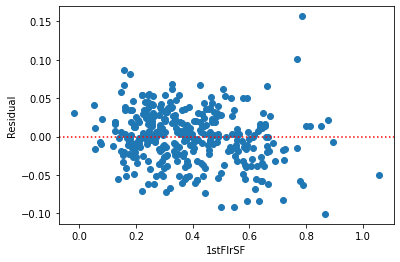

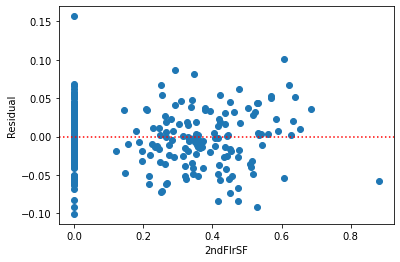

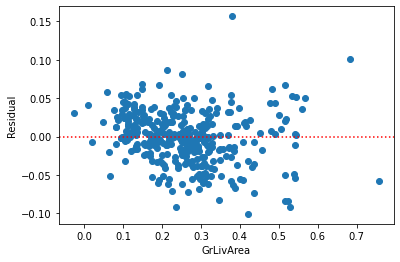

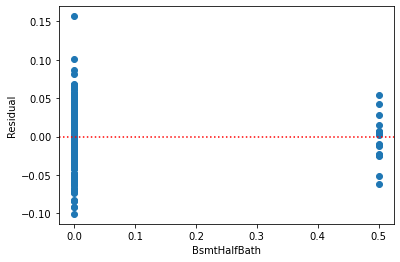

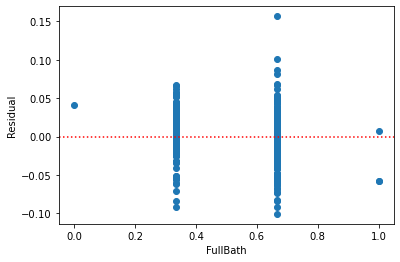

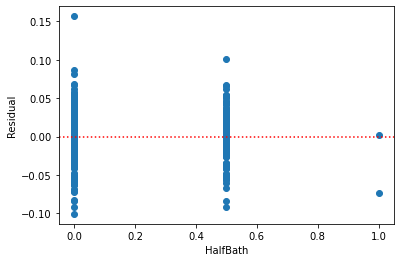

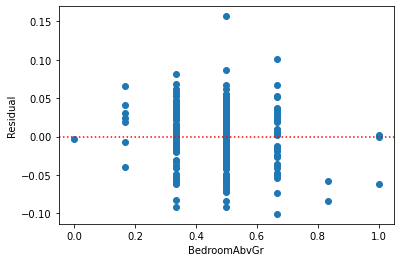

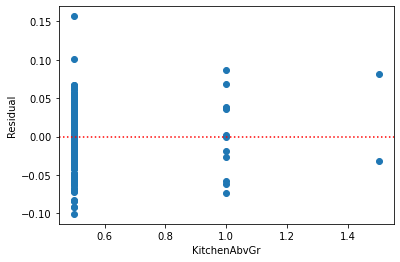

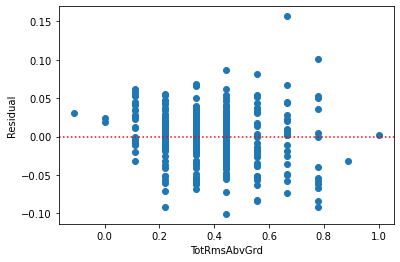

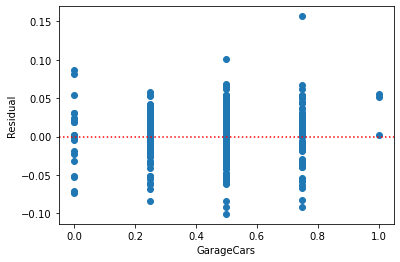

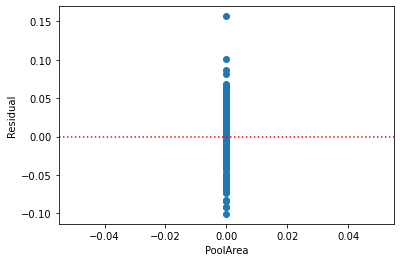

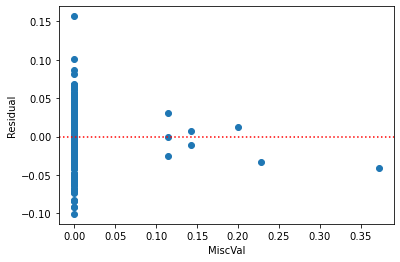

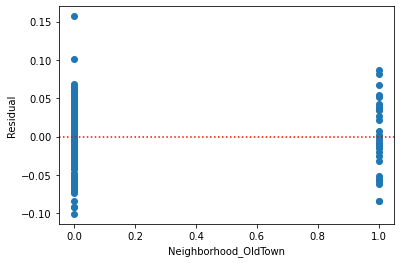

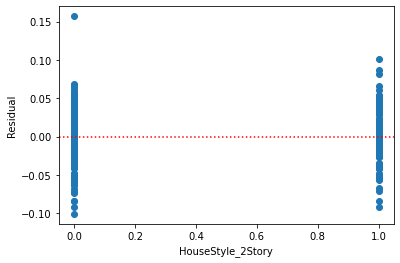

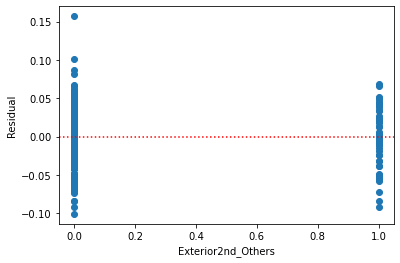

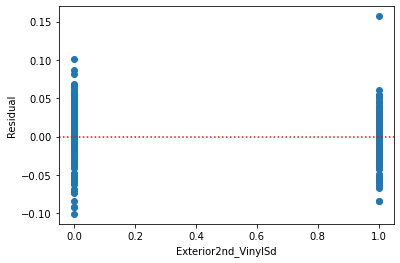

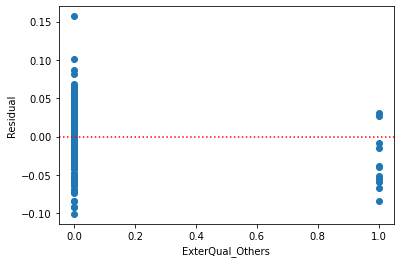

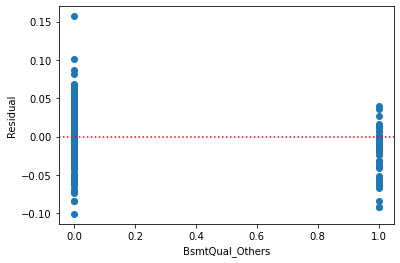

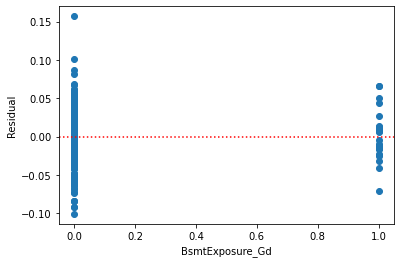

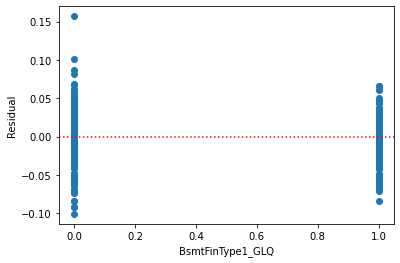

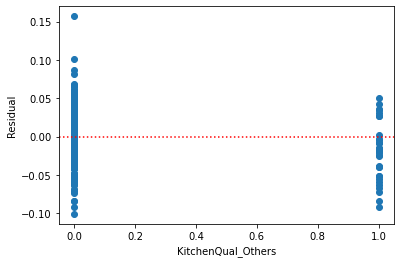

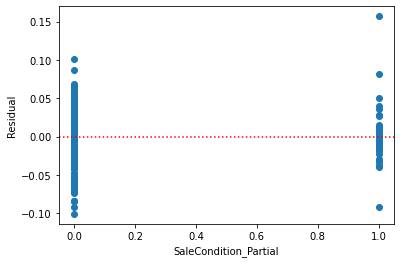

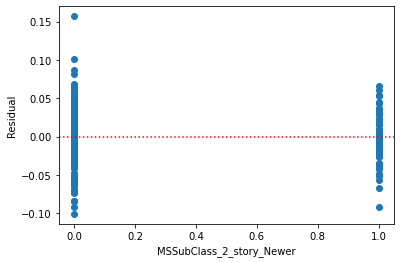

In [116]:
for c in main_col:
    plt.scatter(X_test_new[c] , y_test['res'])
    plt.axhline(y=0, color='r', linestyle=':')
    plt.xlabel(c)
    plt.ylabel("Residual")
    plt.show();
   

In [117]:
main_col

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'PoolArea', 'MiscVal',
       'Neighborhood_OldTown', 'HouseStyle_2Story', 'Exterior2nd_Others',
       'Exterior2nd_VinylSd', 'ExterQual_Others', 'BsmtQual_Others',
       'BsmtExposure_Gd', 'BsmtFinType1_GLQ', 'KitchenQual_Others',
       'SaleCondition_Partial', 'MSSubClass_2_story_Newer'],
      dtype='object')

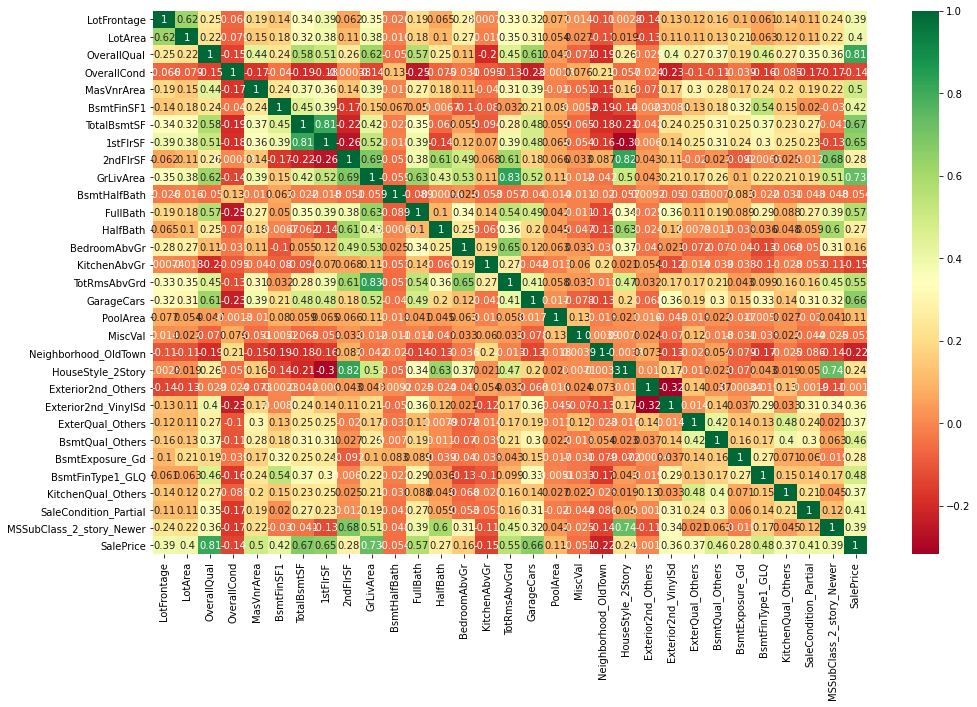

In [118]:
main_col = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'GarageCars', 'PoolArea', 'MiscVal',
       'Neighborhood_OldTown', 'HouseStyle_2Story', 'Exterior2nd_Others',
       'Exterior2nd_VinylSd', 'ExterQual_Others', 'BsmtQual_Others',
       'BsmtExposure_Gd', 'BsmtFinType1_GLQ', 'KitchenQual_Others',
       'SaleCondition_Partial', 'MSSubClass_2_story_Newer', 'SalePrice']

rem_df = price[main_col]
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(rem_df.corr(), annot = True, cmap="RdYlGn")
plt.show()

- From the above heatmap, we can say **`Overall Quality `** (i.e., Rates the overall material and finish of the house) , **`Total Basement Square Feet`** (i.e., Total square feet of basement area), **`First Floor square feet`**, **`Above grade (ground) living area square feet`**, **`Size of garage in car capacity`** are some of the features to be be concentrated on for high Sale Prices with **`linear Regression`**